# Q1 Gillespie's Direct Algorithm and Stochastic Hallmarks

Investigate
1. Variability
2. Negative co-variances
3. Increased transients
4. Stochastic resonance
5. Extinctions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from ndlib.models.CompositeModel import CompositeModel
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.fftpack import rfft, rfftfreq
import scipy.stats as stats
from random import random
from glob import glob
import networkx as nx
import ndlib.models.epidemics as ep

\begin{align}
\frac{dS}{dt} &= \mu -\beta SI - \mu S, \\
\frac{dI}{dt} &= \beta SI - \gamma I- I(\mu + \rho), \\
\frac{dR}{dt} &= \gamma I- \mu R. 
\end{align}

In [2]:
beta_df = pd.read_csv("data/finalbeta.csv")
gamma_df = pd.read_csv("data/finalgamma.csv")
mu_df = pd.read_csv("data/finalmu.csv")
N_df = pd.read_csv("data/finalN.csv")
gamma_N_df = pd.read_csv("data/finalgamma_N.csv")

In [3]:
def determinsteSIR(previousState, t, beta, gamma, birth_rate):
    state = np.empty(3)
    X, Y, Z = previousState
    state[0] = birth_rate - X * birth_rate - X * Y * beta
    state[1] = X * Y * beta - Y * birth_rate - Y * gamma
    state[2] = Y * gamma - Z * birth_rate
    return state


def return_Solved(beta, gamma, mu, N, step):
    XYZ = [1, 1 / N, 0]
    t = np.linspace(0, 365, step)

    solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, mu))
    return solved


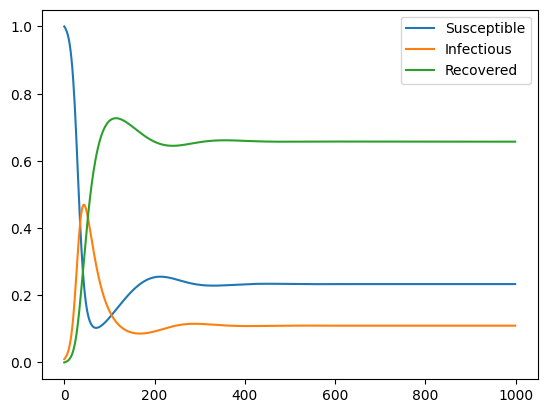

In [17]:
XYZ = [1, 0.01, 0]
t = np.linspace(0, 365, 1000)
beta = 1/2
gamma = 1/10
mu = 1 / 60

solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, mu))
plt.plot(solved[:, 0], label="Susceptible")
plt.plot(solved[:, 1], label="Infectious")
plt.plot(solved[:, 2], label="Recovered")
plt.legend(loc="best")

In [4]:
def stoch_sir(XYZ, N, tend, beta, gamma, mu):
    # Columns: SIR, Rows: Events [infect, recovery, birth, death S, death I, death R]
    change_matrix = np.array(
        [[-1, 1, 0],
         [0, -1, 1],
         [1, 0, 0],
         [-1, 0, 0],
         [0, -1, 0],
         [0, 0, -1]
         ])
    current_t = 0
    ts = 0.1
    T = [0]
    S = [XYZ[0]]
    I = [XYZ[1]]
    R = [XYZ[2]]

    while T[current_t] < tend:
        T.append(T[-1] + ts)
        S.append(XYZ[0])
        I.append(XYZ[1])
        R.append(XYZ[2])

        event_rates = ([(beta * XYZ[0] * XYZ[1]) / N, gamma * XYZ[1],
                        mu * N, mu * XYZ[0], mu * XYZ[1], mu * XYZ[2]])

        rand_1 = random()
        rand_2 = random()
        ts = -np.log(rand_1) / (np.sum(event_rates))

        p = rand_2 * np.sum(event_rates)
        event_index = min(np.nonzero(np.ravel(np.cumsum(event_rates) >= p))[0])

        XYZ = XYZ + change_matrix[event_index, :]

        current_t = current_t + 1
    return [T, S, I, R]


def run_simulations(number_of_runs, name, param, kwargs):
    for i in range(number_of_runs):
        df = pd.DataFrame(stoch_sir(**kwargs))
        for column in kwargs.keys():
            df[column] = [kwargs[column] for x in range(len(df))]
        df["group"] = ["S", "I", "R"]
        df.to_csv(f"seeddata/{name.capitalize()}{param:.2f}stochasticSIR{i + 1}.csv", index=False)

# [T, S, I, R] = stoch_sir(XYZ)

# data_T = np.array(T)
# data_S = np.array(S)/10000
# data_I = np.array(I)/10000
# data_R = np.array(R)/10000

# data_T = np.array(T)
# data_S = np.array(S)/10000
# data_I = np.array(I)/10000
# data_R = np.array(R)/10000

# plt.plot(data_T, data_S, data_T, data_I, data_T, data_R)
# plt.xlabel("Days")
# plt.ylabel("Population Fraction")
# plt.legend(["Susceptible", "Infected", "Recovered"])
# plt.show()


## Investigate Simulation variability and Negative Co-variance

> Investigate how varying the model parameters changes the behavior of the stochastic dynamics. How do the related to the variance between runs and the negative covariance between $S$ and $I$.

> Compare the mean of the stochatic models to their deterministic counter parts

beta = 0.22
Covariance between S and I = -345625.20537815103

Variance for S = 4579972.46347489
Variance for I = 350080.09216311
Variance for R = 4309144.8964579115

beta = 1.27
Covariance between S and I = -138082.7054067342

Variance for S = 1758533.944979365
Variance for I = 1104795.4689525336
Variance for R = 2593375.6208724882
beta = 2.32
Covariance between S and I = -47179.17563150411

Variance for S = 950324.2947120103
Variance for I = 1337740.8985268374
Variance for R = 2161800.1225485313

beta = 3.37
Covariance between S and I = -32479.13693437666

Variance for S = 694640.3656803312
Variance for I = 1359364.8904444762
Variance for R = 2015568.9943743793


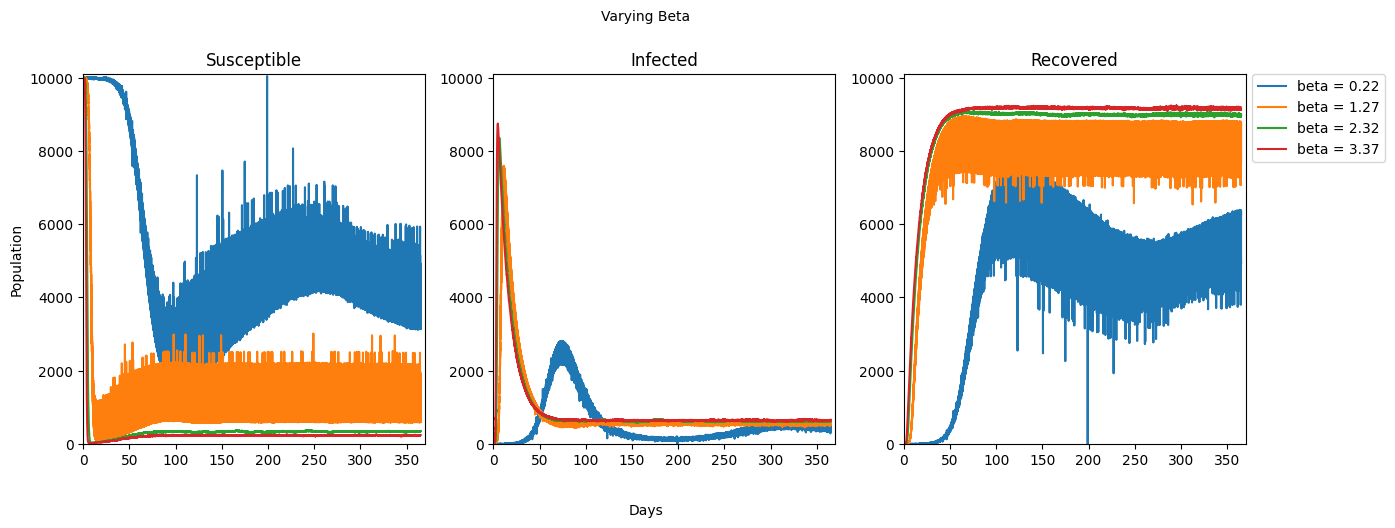

In [5]:
#Reading in the beta data (lol it rhymes hee hee. I'm a bit delirious right now). 

def sortHelper(x):
    try:
        return float(x)
    except: 
        return 100000
dfs = [beta_df, gamma_df, mu_df, N_df, gamma_N_df]

for df in dfs:
    df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1, inplace=True) 

sorted_columns = sorted(beta_df.columns, key=sortHelper)

beta_df = beta_df.reindex(columns=sorted_columns)

grouped = beta_df.groupby(["group"])
grouped_beta = beta_df.groupby(["group", "beta"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in beta_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data


for paramVal in beta_df["beta"].unique()[1::5]:
    axs[0].plot(numbers, grouped_beta.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_beta.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_beta.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"beta = {paramVal:.{2}f}")
    cov = np.cov(grouped_beta.loc[("S", paramVal)][:-6].dropna(), grouped_beta.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_beta.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_beta.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_beta.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Beta", ha='center', va='center', rotation='horizontal')
legend_labels = [f"beta = {paramVal:.{2}f}" for paramVal in beta_df["beta"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


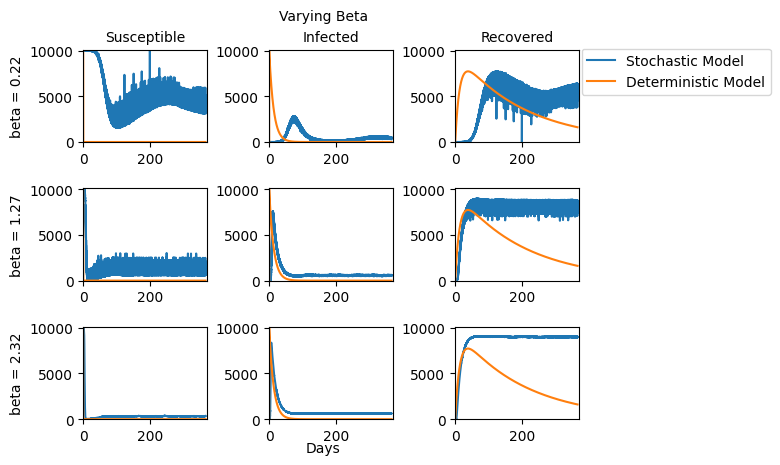

In [21]:
#Setting the figure
fig, axs = plt.subplots(3, 3)

# Plotting the data
t1 = np.linspace(0, 365, len(numbers))

for i in range(3): 
    paramVals = beta_df["beta"].unique()[1::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (paramVals[i], beta_df["gamma"][0], beta_df["mu"][0]))
    axs[i,0].plot(numbers, grouped_beta.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_beta.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_beta.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"beta = {round(paramVals[i], 2)}")
    
    
axs[0,0].set_title("Susceptible", fontsize = 10)
axs[0,1].set_title("Infected", fontsize = 10)
axs[0,2].set_title("Recovered", fontsize = 10)


fig.text(0.5, 0.05, "Days", ha='center', va='center')
fig.text(0.5, 0.95, "Varying Beta", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 4.01), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


gamma = 0.22
Covariance between S and I = -35396.72955239162

Variance for S = 748107.9335788947
Variance for I = 19772.217871259578
Variance for R = 691527.3923112763

gamma = 0.14
Covariance between S and I = -110615.7982919235

Variance for S = 1808768.777221275
Variance for I = 147259.15577635003
Variance for R = 1756228.3332891809

gamma = 0.29
Covariance between S and I = -15771.541749126556

Variance for S = 506887.1635694167
Variance for I = 5273.948517134851
Variance for R = 474101.2710355077
gamma = 0.42
Covariance between S and I = -0.12241481192293355

Variance for S = 505.0947846553558
Variance for I = 0.005381580038494857
Variance for R = 0.2208187946621726


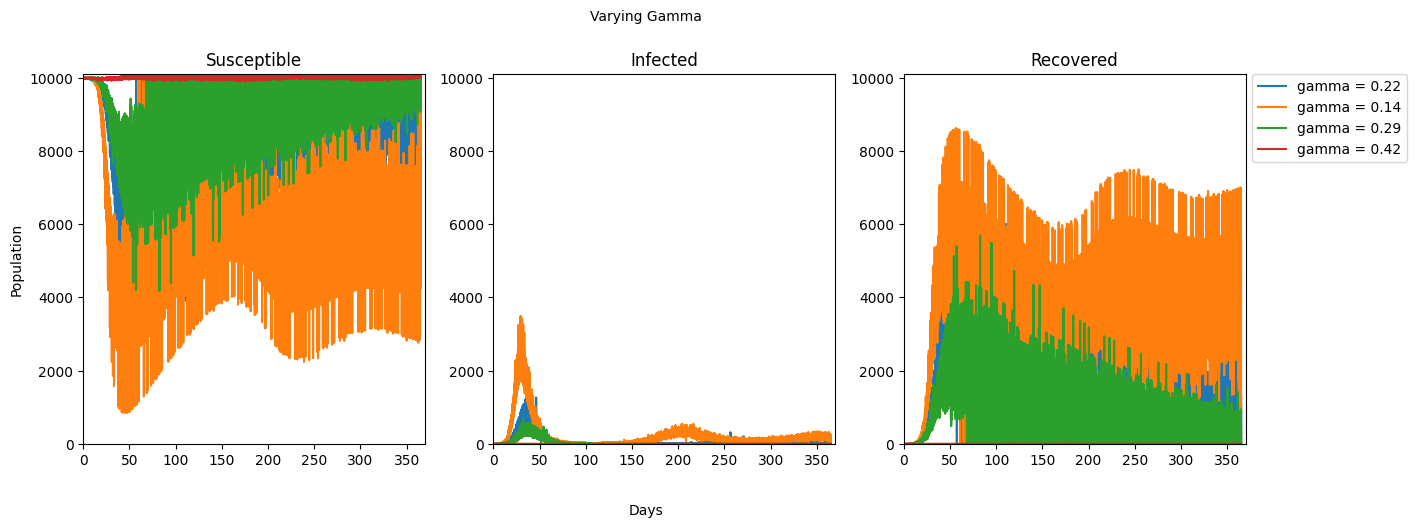

In [22]:
#Reading in the gamma data (lol it rhymes hee hee. I'm a bit delirious right now). ### You and me both buddy

grouped = gamma_df.groupby(["group"])
grouped_gamma = gamma_df.groupby(["group", "gamma"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in gamma_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data

for paramVal in gamma_df["gamma"].unique()[1::5]:
    axs[0].plot(numbers, grouped_gamma.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_gamma.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_gamma.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"gamma = {paramVal:.{2}f}")
    cov = np.cov(grouped_gamma.loc[("S", paramVal)][:-6].dropna(), grouped_gamma.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_gamma.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_gamma.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_gamma.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Gamma", ha='center', va='center', rotation='horizontal')
legend_labels = [f"gamma = {paramVal:.{2}f}" for paramVal in gamma_df["gamma"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


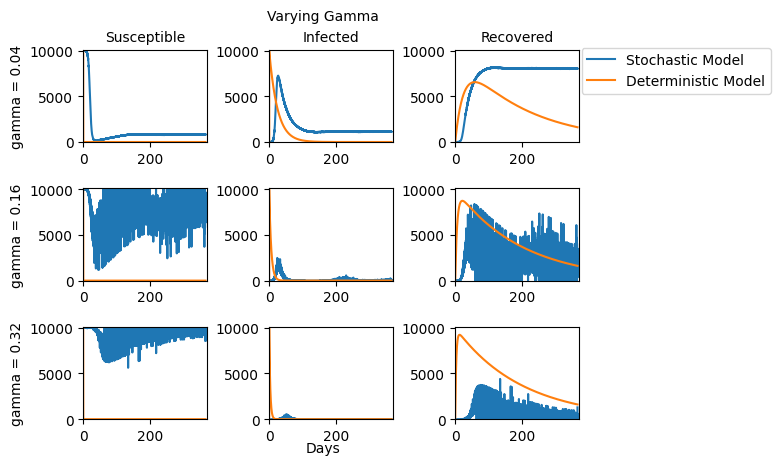

In [23]:
#Setting the figure
fig, axs = plt.subplots(3, 3)
# fig.set_figwidth(8)
# fig.set_figheight(8)
# Plotting the data

t1 = np.linspace(0, 365, len(numbers))


for i in range(3): 
    paramVals = gamma_df["gamma"].unique()[2::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (gamma_df["beta"][0], paramVals[i], gamma_df["mu"][0]))
    axs[i,0].plot(numbers, grouped_gamma.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_gamma.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_gamma.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"gamma = {round(paramVals[i], 2)}")

axs[0,0].set_title("Susceptible", fontsize = 10)
axs[0,1].set_title("Infected", fontsize = 10)
axs[0,2].set_title("Recovered", fontsize = 10)


fig.text(0.5, 0.05, "Days", ha='center', va='center')
fig.text(0.5, 0.95, "Varying Gamma", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 4.02), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


mu = 0.02
Covariance between S and I = -444072.0135004547

Variance for S = 2047138.142519091
Variance for I = 324274.7228861258
Variance for R = 1475193.5723492906

mu = 0.07
Covariance between S and I = -623933.7494230488

Variance for S = 1329278.0570609288
Variance for I = 324541.8537938637
Variance for R = 399028.5122747744


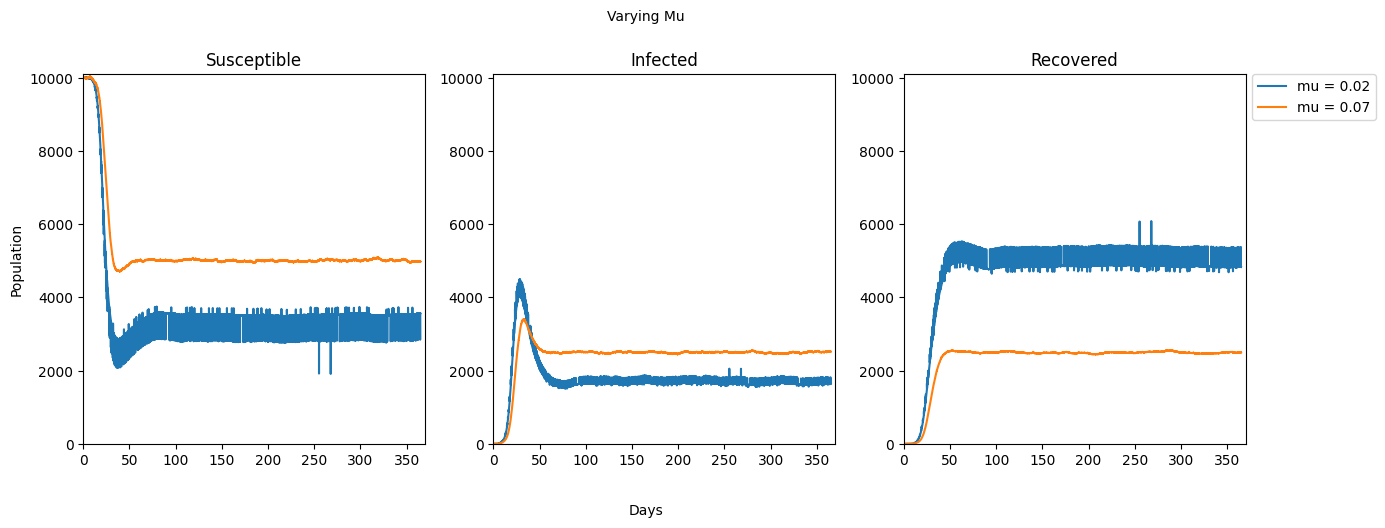

In [24]:
#Reading in the Mu data (lol it rhymes hee hee. I'm a bit delirious right now). 

grouped = mu_df.groupby(["group"])
grouped_mu = mu_df.groupby(["group", "mu"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in mu_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data

for paramVal in mu_df["mu"].unique()[1::5]:
    axs[0].plot(numbers, grouped_mu.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_mu.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_mu.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"mu = {paramVal:.{2}f}")
    cov = np.cov(grouped_mu.loc[("S", paramVal)][:-6].dropna(), grouped_mu.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_mu.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_mu.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_mu.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Mu", ha='center', va='center', rotation='horizontal')
legend_labels = [f"mu = {paramVal:.{2}f}" for paramVal in mu_df["mu"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


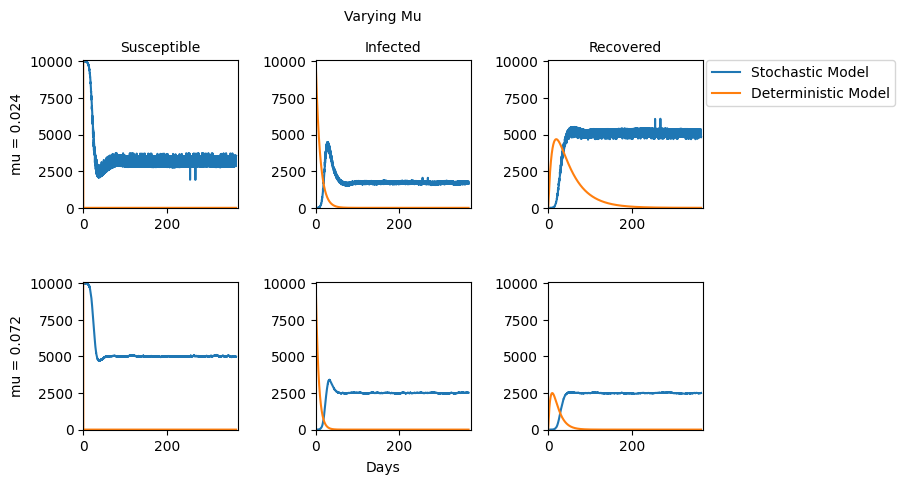

In [25]:
#Setting the figure
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(8)

# Plotting the data

t1 = np.linspace(0, 365, len(numbers))


for i in range(2): 
    paramVals = mu_df["mu"].unique()[1::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (mu_df["beta"][0], mu_df["gamma"][0], paramVals[i]))
    axs[i,0].plot(numbers, grouped_mu.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_mu.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_mu.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"mu = {round(paramVals[i], 3)}")


axs[0,0].set_title("Susceptible", fontsize = 10)
axs[0,1].set_title("Infected", fontsize = 10)
axs[0,2].set_title("Recovered", fontsize = 10)


fig.text(0.5, 0.03, "Days", ha='center', va='center')
fig.text(0.5, 0.97, "Varying Mu", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 2.5), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

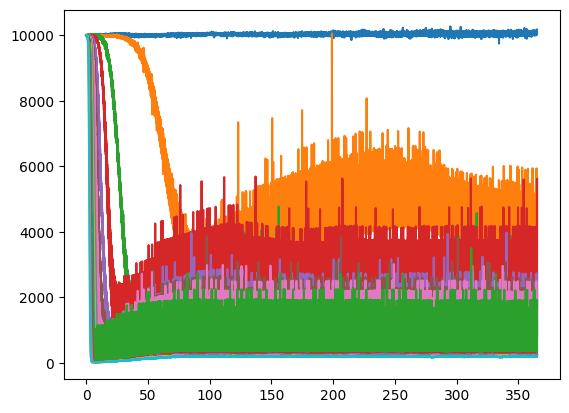

In [26]:
grouped = beta_df.groupby(["group"])
grouped_beta = beta_df.groupby(["group", "beta"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in beta_df.columns[1:-6]]

# Plotting the data
#plt.plot(numbers, mean_stoch.loc["S"][:-7])
for i in beta_df["beta"].unique():
    plt.plot(numbers, grouped_beta.loc[("S", i)][:-5])

plt.show()


## Stochastic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance around the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

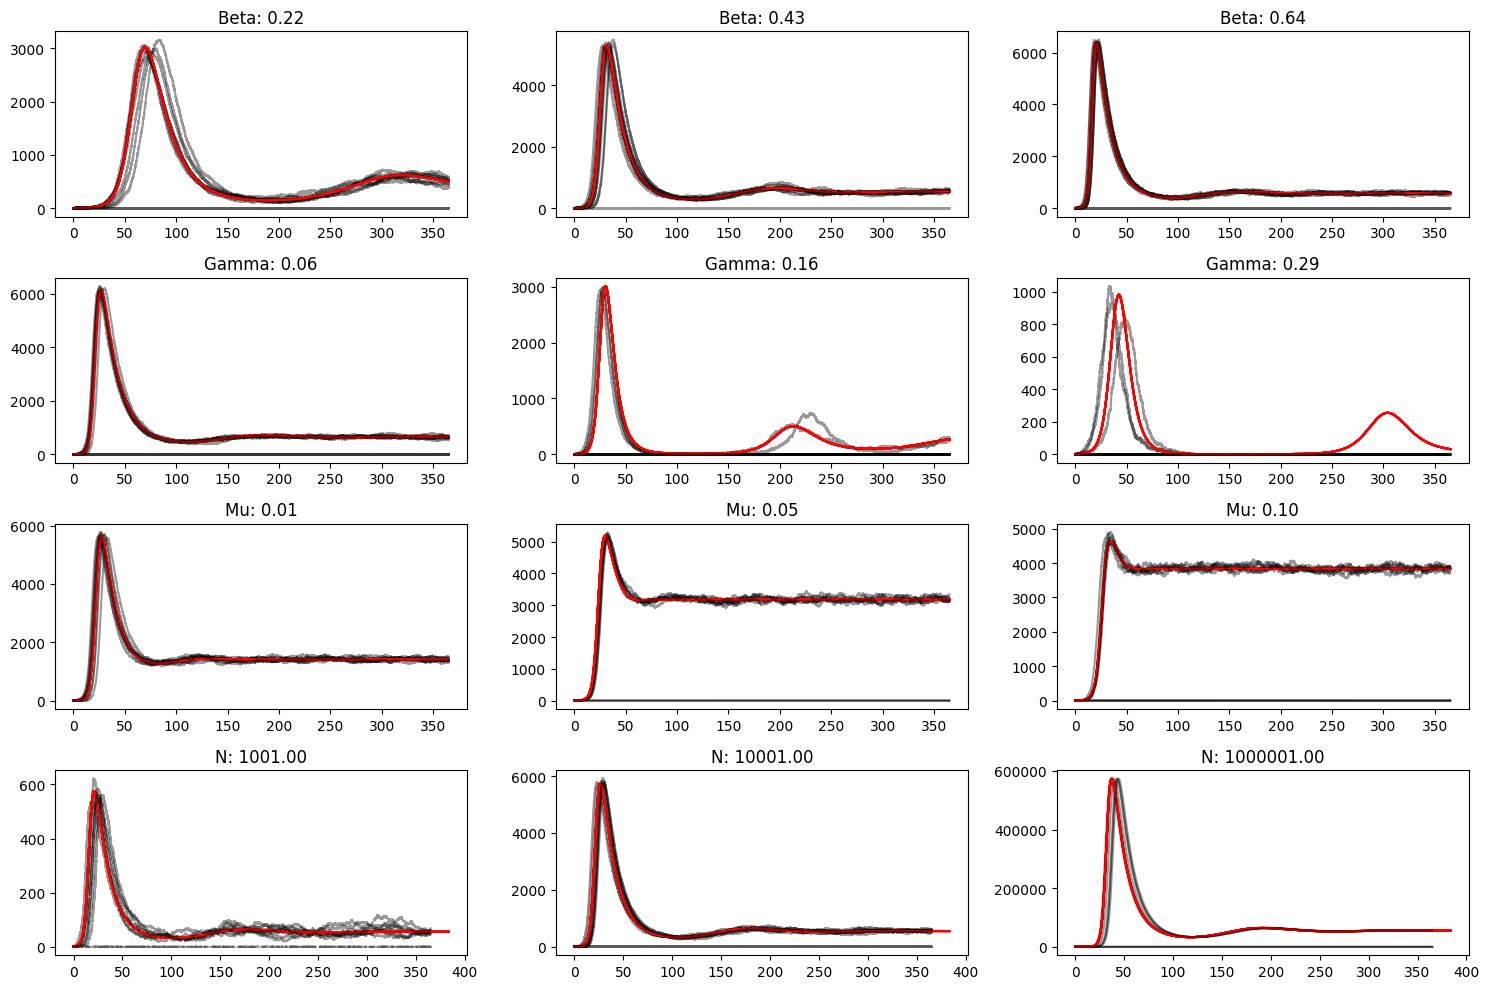

In [24]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
axs = axs.ravel()

def plt_row(df, param, plot_start):
    values = df[param].unique()
    values.sort()
    idx = np.linspace(0, len(values)-1, 3).astype(int)
    
    for plot, current_param in enumerate(values[idx], start = plot_start):
        intervals = [float(x) for x in df.columns[1:-6]]
        filtered_df = df.loc[(df[param] == current_param) & (df["group"] == "I")]
        
        for i in range(10):
            kwargs = {}
            parameters = ["beta","gamma","mu","N"]
            parameters.remove(param)
            
            for x in parameters:
                kwargs[x] = df[x].unique()[0]
            kwargs[param] = current_param
            
            determinist_data = return_Solved(**kwargs, step = len(intervals))[:, 1] * kwargs["N"]
            mult = current_param ** (param == "N") #If we are currently plotting for change in N, we need to multiply by N because the data was normalized to 1
            axs[plot].plot(intervals, determinist_data, color="r")
            axs[plot].plot(intervals, filtered_df.iloc[i, 1:-6] * mult, color ="black", alpha= 0.4)
            axs[plot].set_title(f"{param.capitalize()}: {current_param:.2f}")

plt_row(beta_df.loc[(0.1 < beta_df["beta"]) & (beta_df["beta"] < 0.85)], "beta", 0)
plt_row(gamma_df.loc[(0.05 < gamma_df["gamma"]) & (gamma_df["gamma"] < 0.3 )], "gamma",3)
plt_row(mu_df, "mu",6)
plt_row(N_df.loc[N_df["N"] > 999], "N",9)
plt.tight_layout()
plt.savefig("Plot", dpi=500)

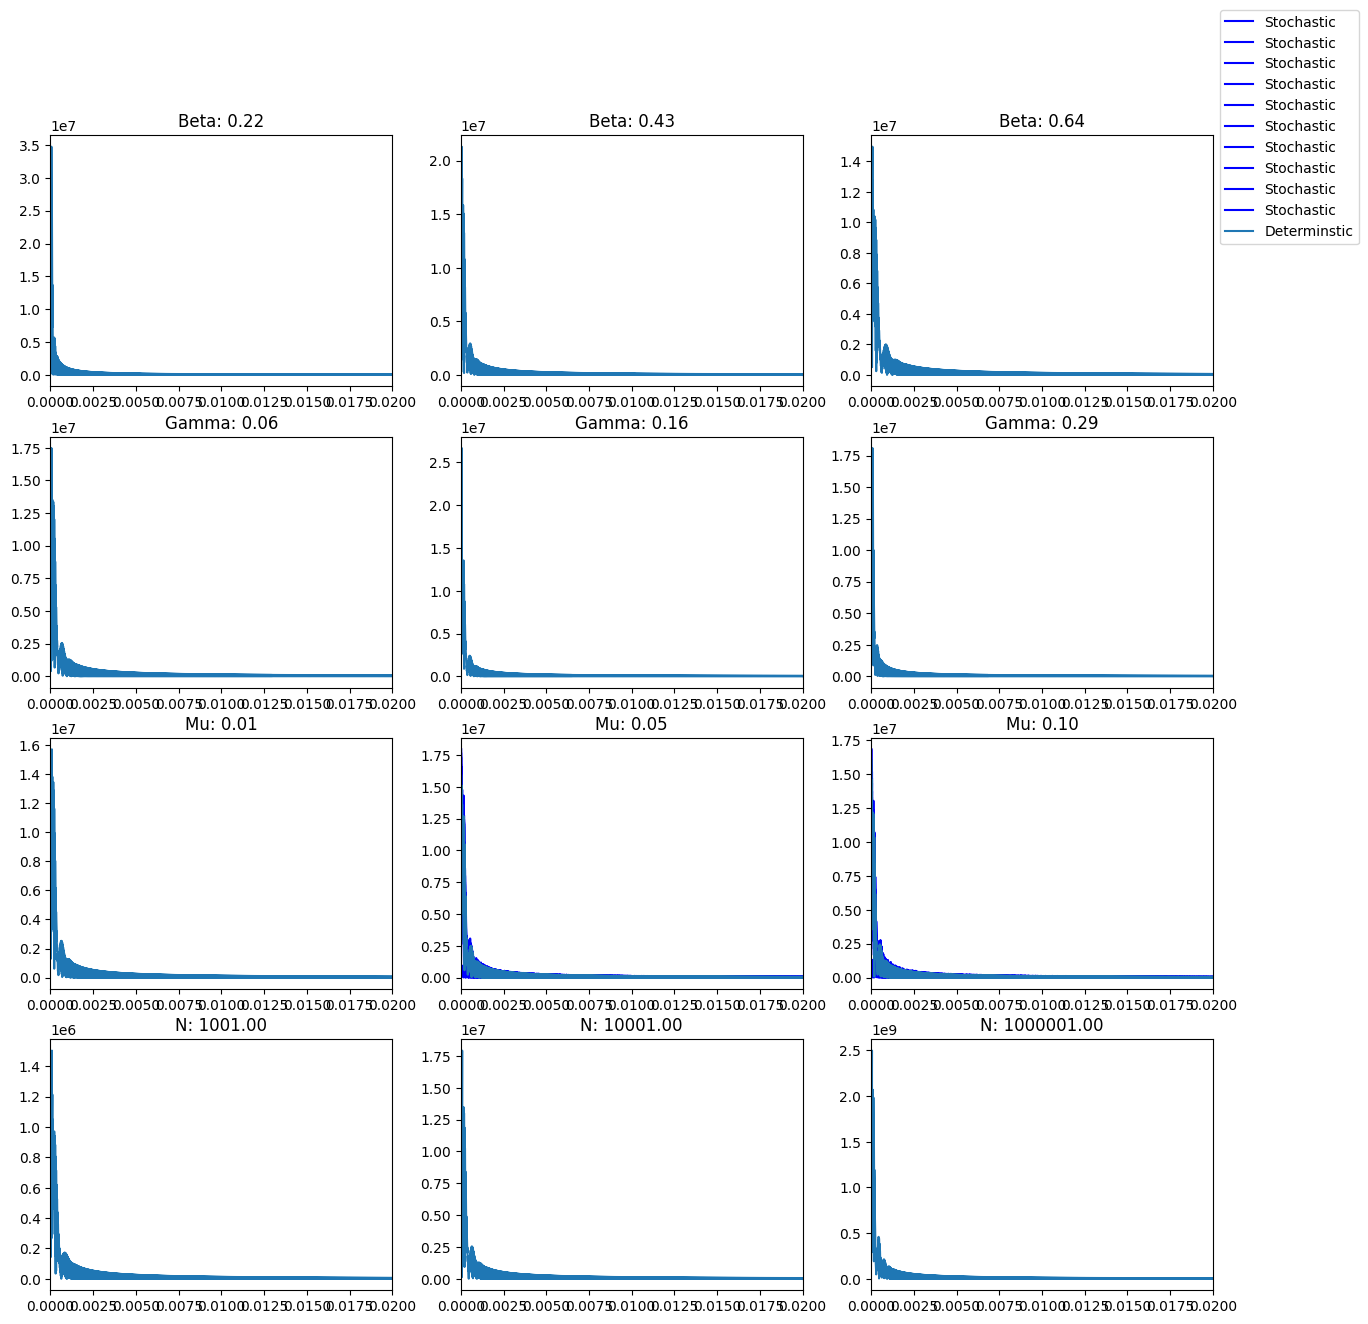

In [38]:
## When you really think about it, has FFT every made anyone happy? I this a method we really need to be condoning in research?? I think not, let's stop the FFT tyranny and accept that our eyes can just see the waves
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
axs = axs.ravel()
def get_fft(data):
    data -= np.mean(data)
    fft_result = rfft(data)
    
    frequencies = rfftfreq(len(data))
    
    non_dc_indices = np.where(frequencies != 0.0)
    frequencies = frequencies[non_dc_indices]
    fft_result = fft_result[non_dc_indices]
    magnitudes = np.abs(fft_result)
    return frequencies, magnitudes
    
def plotFFT(df, param, plot_start):
    values = df[param].unique()
    values.sort()
    idx = np.linspace(0, len(values)-1, 3).astype(int)

    kwargs = {}
    parameters = ["beta","gamma","mu","N"]
    parameters.remove(param)
    for x in parameters:
        kwargs[x] = df[x].unique()[0]
    
    intervals = [float(x) for x in df.columns[1:-6]]
    for plot,i in enumerate(values[idx],start = plot_start):
        mult = i ** (param == "N") #If we are currently plotting for change in N, we need to multiply by N because the data was normalized to 1
        kwargs[param] = i 
        for x in range(10):
            stochastic_data = df.loc[(df[param] == i) & (df["group"] == "S")].iloc[x][:36400].to_numpy() * mult
            stochastic_freqs, stochastic_mags = get_fft(stochastic_data)
            axs[plot].plot(stochastic_freqs, stochastic_mags, color = "b", label = "Stochastic")
        
        determinist_data = return_Solved(**kwargs, step = len(intervals))[:36400, 0] * kwargs["N"]
        determinist_freqs, determinist_mags = get_fft(determinist_data)
        axs[plot].plot(determinist_freqs, determinist_mags, label = "Determinstic")
        axs[plot].set_title(f"{param.capitalize()}: {i:.2f}")
        axs[plot].set_xlim((0,0.02))
        # axs[plot].set_ylim((0,100000))

plotFFT(beta_df.loc[(0.1 < beta_df["beta"]) & (beta_df["beta"] < 0.85)], "beta", 0)
plotFFT(gamma_df.loc[(0.05 < gamma_df["gamma"]) & (gamma_df["gamma"] < 0.3)], "gamma",3)
plotFFT(mu_df, "mu",6)
plotFFT(N_df.loc[N_df["N"] > 999], "N",9)
axs[2].legend(bbox_to_anchor=(1.02, 1.5), loc='upper left', borderaxespad=0)
# plt.tight_layout()
plt.savefig("Plot", dpi=500)

## Stochastic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance around the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

## Extinction events and Critical Community Size
> Design an experiment that shows the effect of varying $R_0$ on the extinction process. *Keep in mind that in the closed system randomness will always eventually lead to extinction*. 

> Look at how the extinction events are impacted by the population size. Find a way to show how the two parameter $R_0$ and $N$ ineract to impact the extinction process.

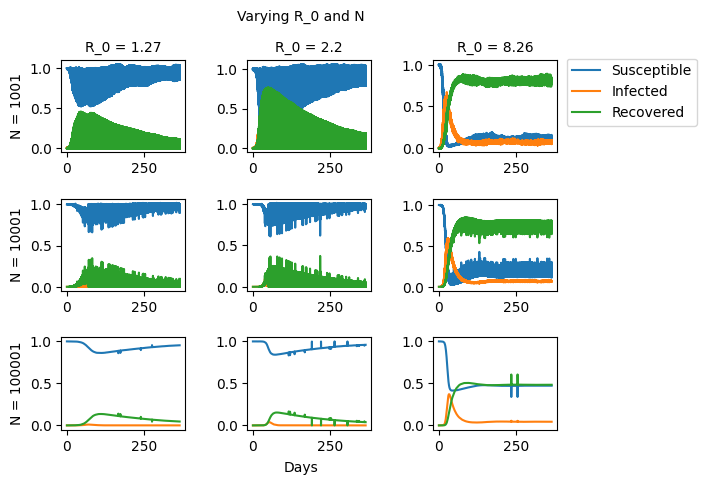

In [29]:
grouped = gamma_N_df.groupby(["group"])
grouped_R = gamma_N_df.groupby(["group", "N", "gamma"]).mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in gamma_N_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(3, 3)

# Plotting the data
paramVals_N = gamma_N_df["N"].unique()[:-1]
paramVals_gamma = gamma_N_df["gamma"].unique()[1::3]
paramVals_gamma = paramVals_gamma[::-1]

for i in range(3): 
    for j in range(3):
        axs[i,j].plot(numbers, grouped_R.loc[("S", paramVals_N[i], paramVals_gamma[j])][:-5], label='Susceptible')
        axs[i,j].plot(numbers, grouped_R.loc[("I", paramVals_N[i], paramVals_gamma[j])][:-5], label='Infected')
        axs[i,j].plot(numbers, grouped_R.loc[("R", paramVals_N[i], paramVals_gamma[j])][:-5], label='Recovered')
    axs[i,0].set_ylabel(f"N = {round(paramVals_N[i], 2)}")
    axs[0,i].set_title(f"R_0 = {round(0.5/(paramVals_gamma[i] + 0.005), 2)}", fontsize = 10)

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 4.09))
fig.text(0.5, 0.03, "Days", ha='center', va='center')
fig.text(0.5, 0.97, "Varying R_0 and N", ha='center', va='center', rotation='horizontal')
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


## SIR Model on Networks

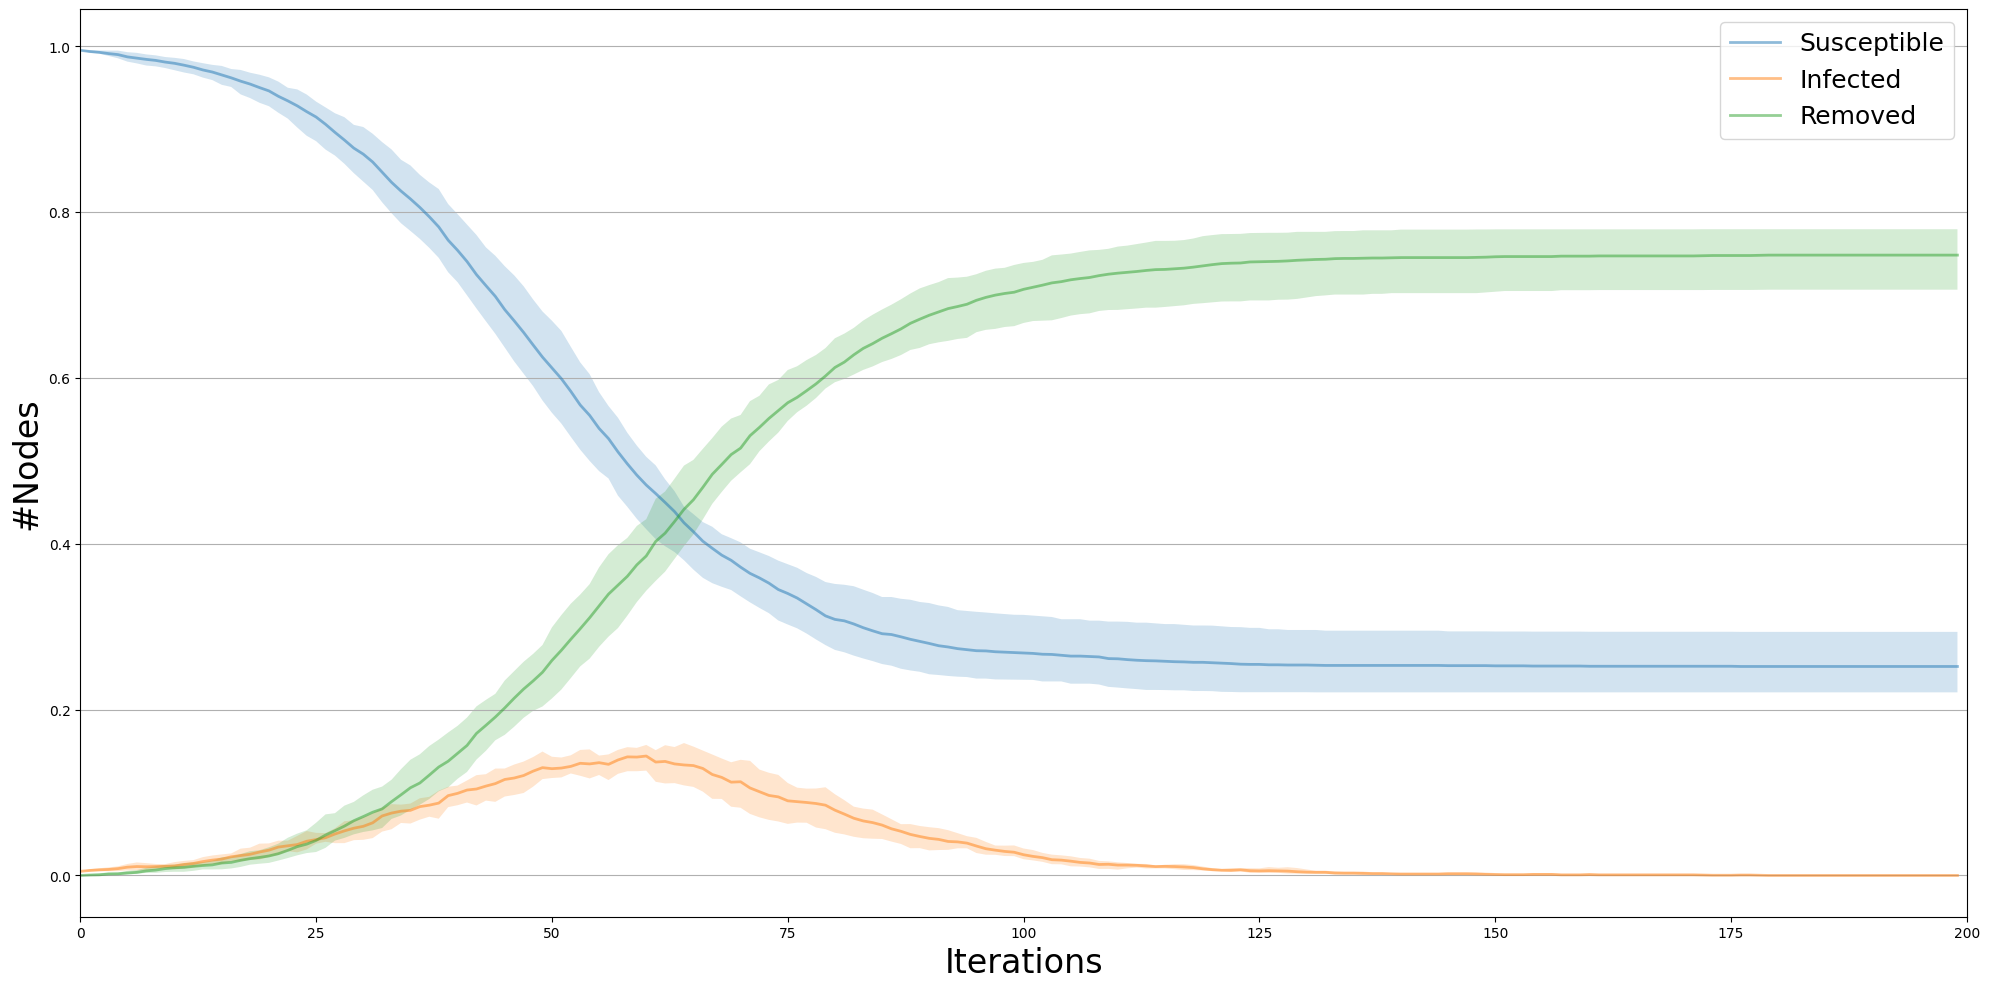

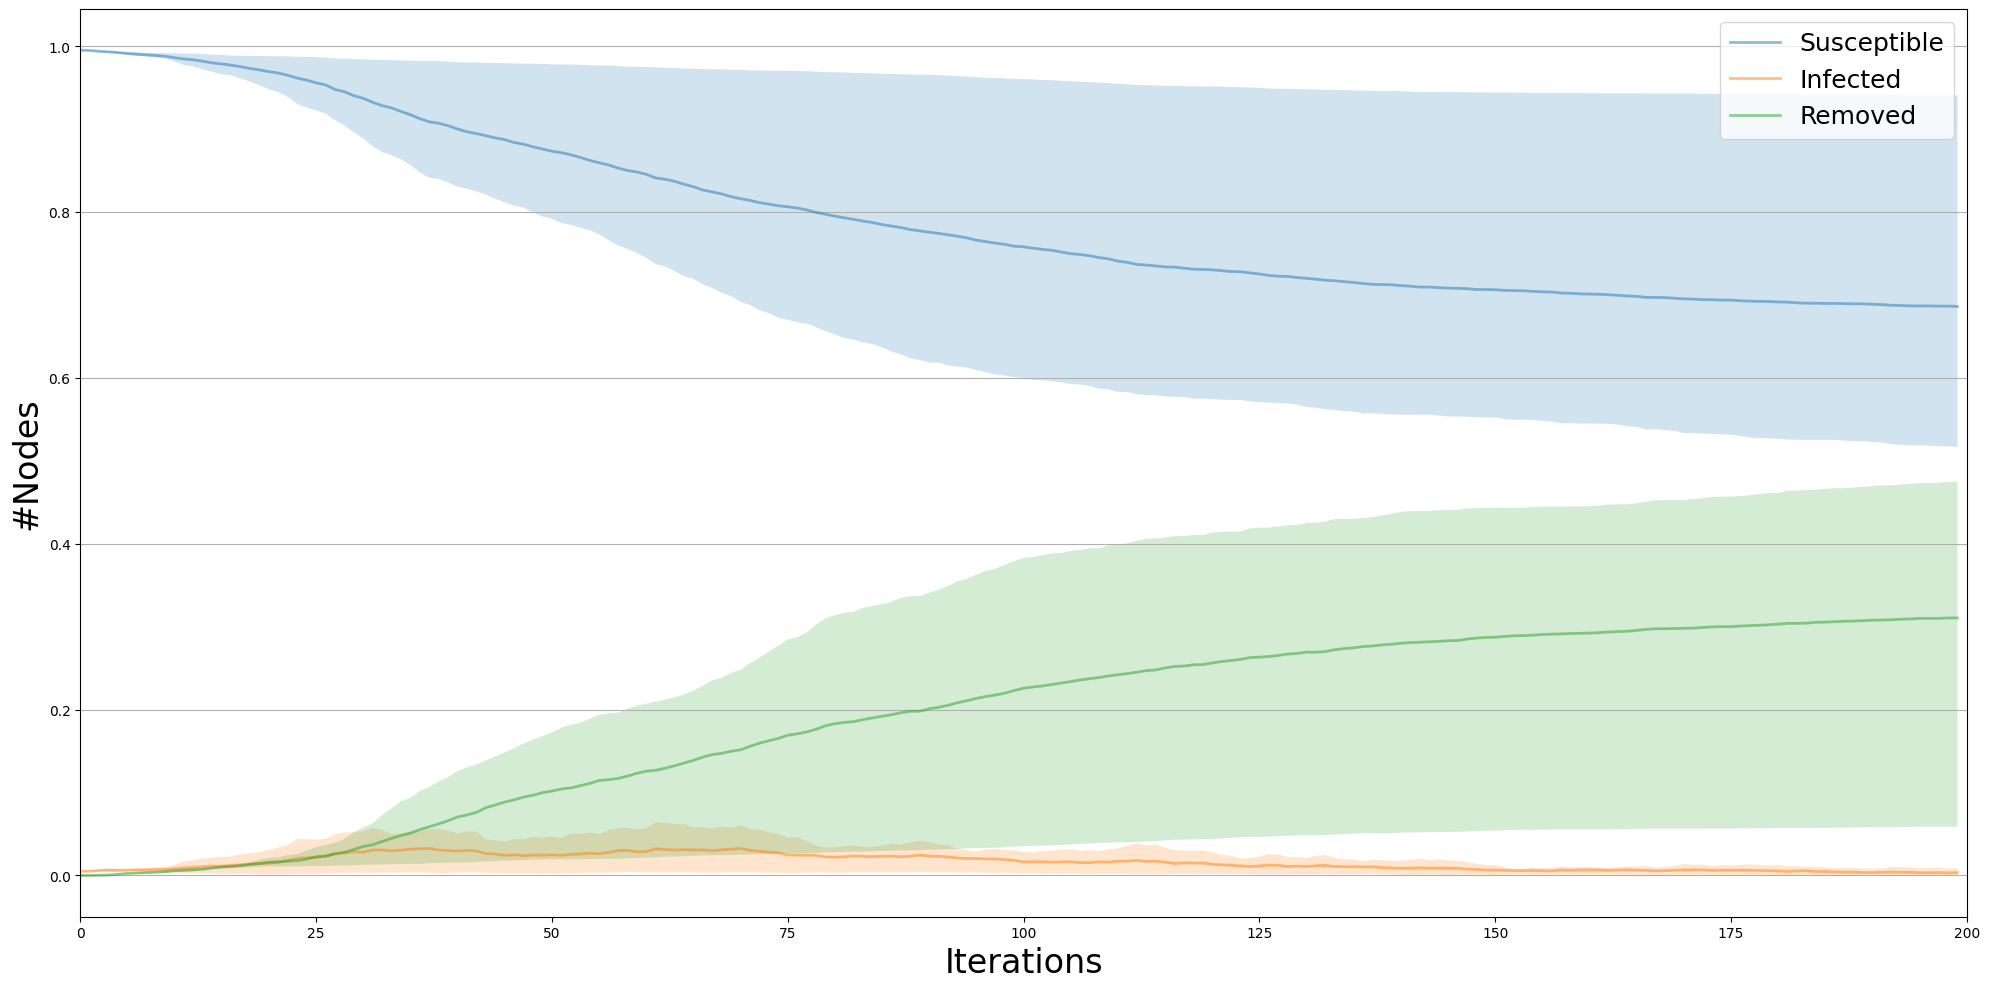

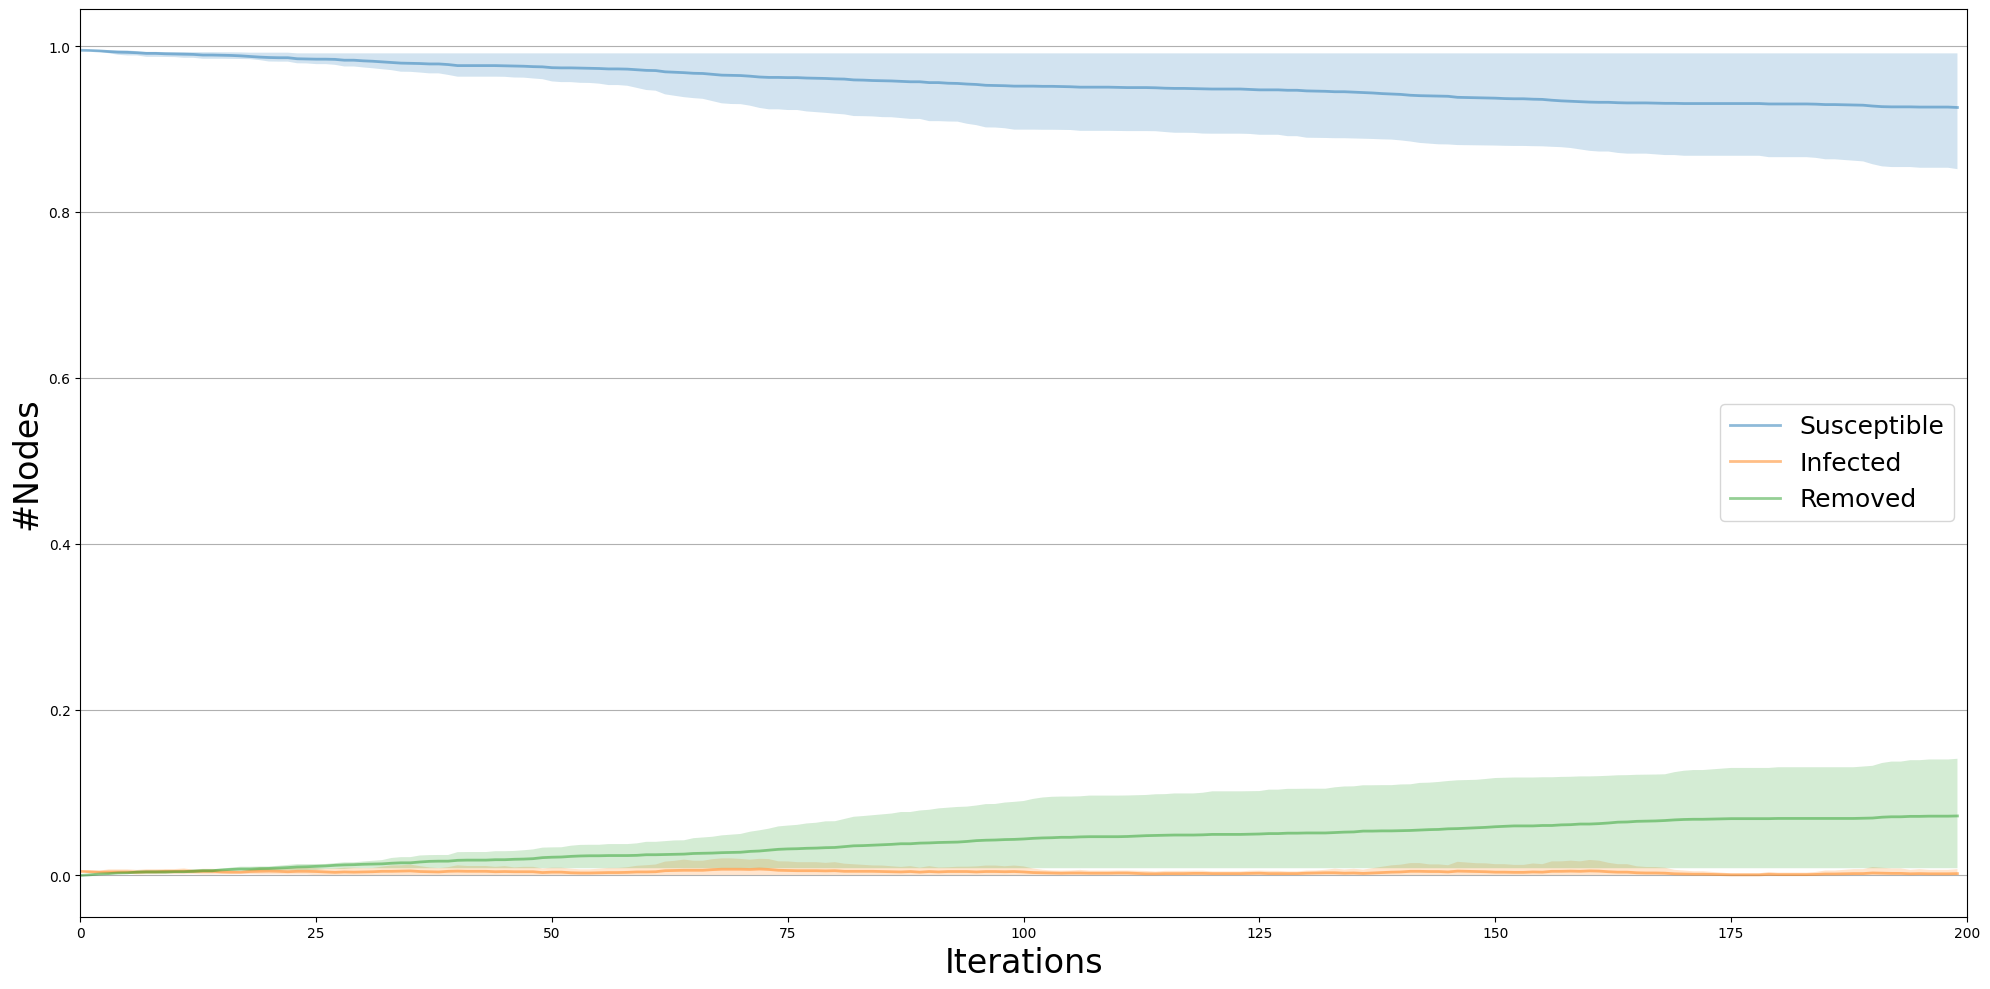

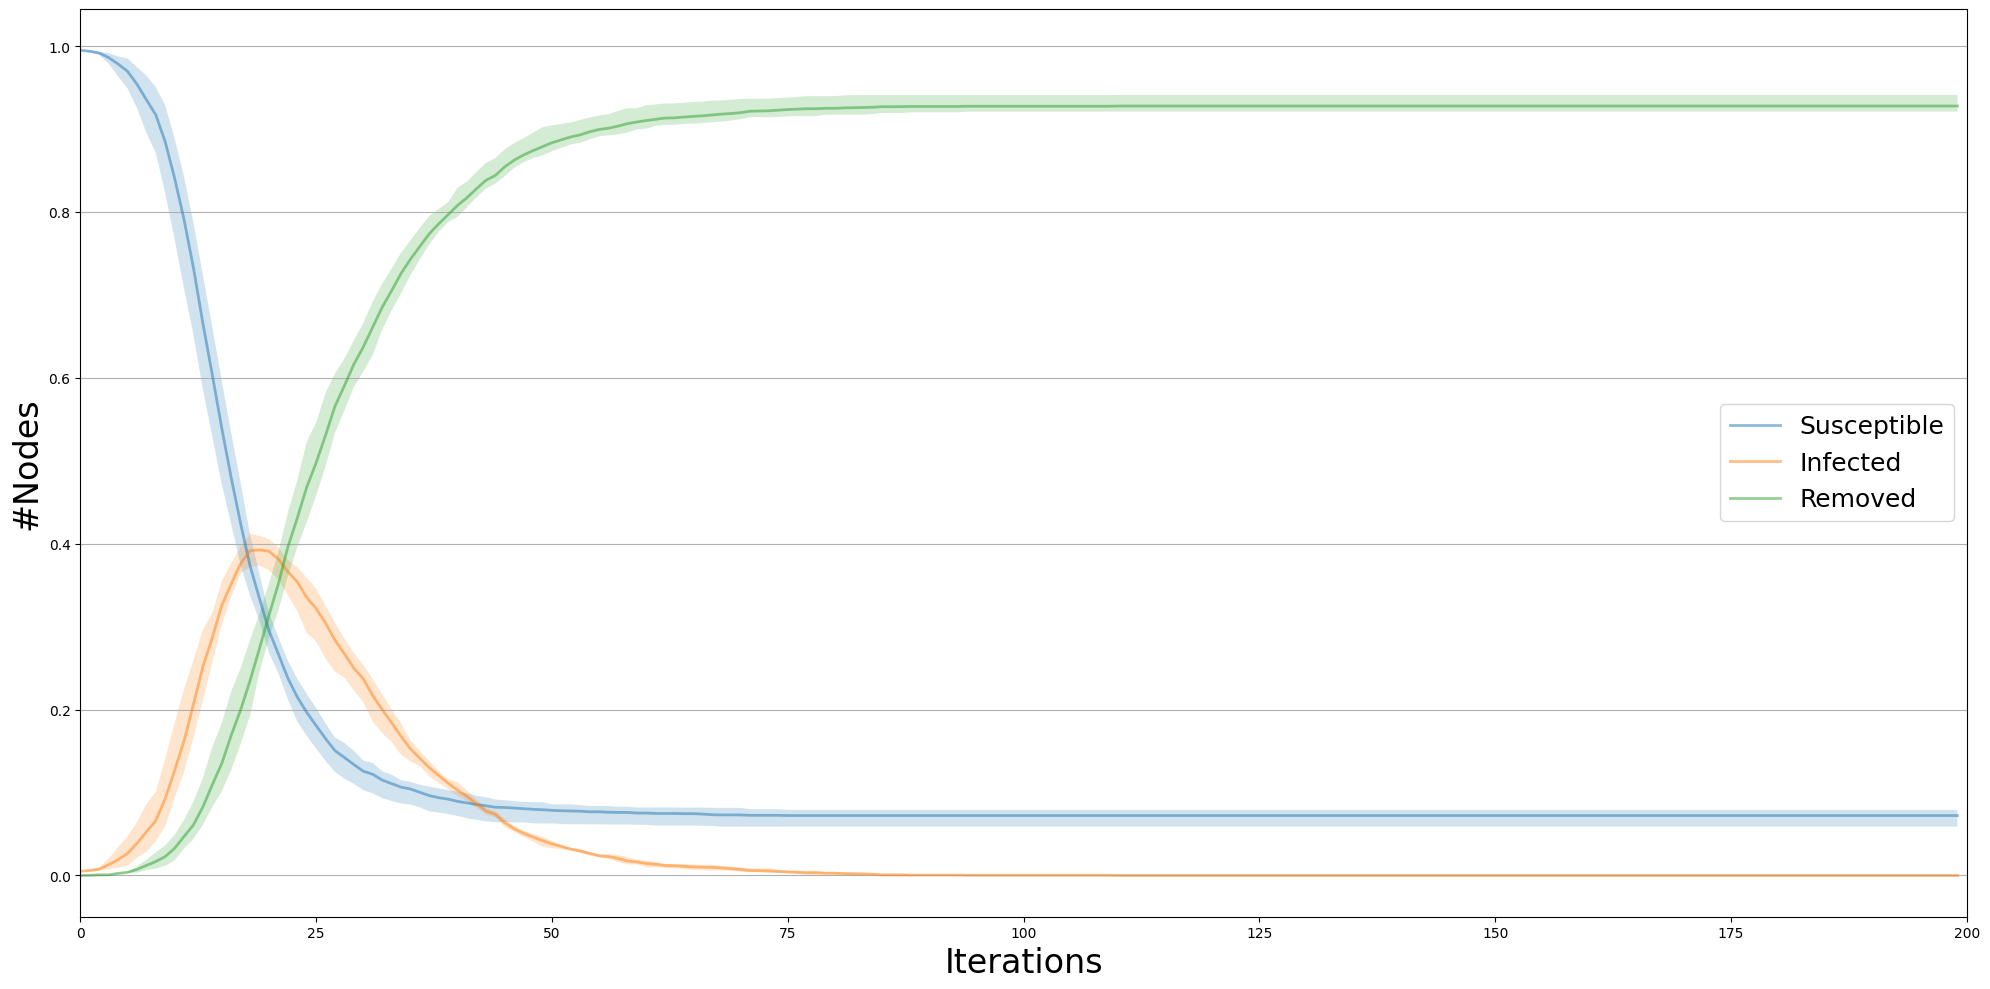

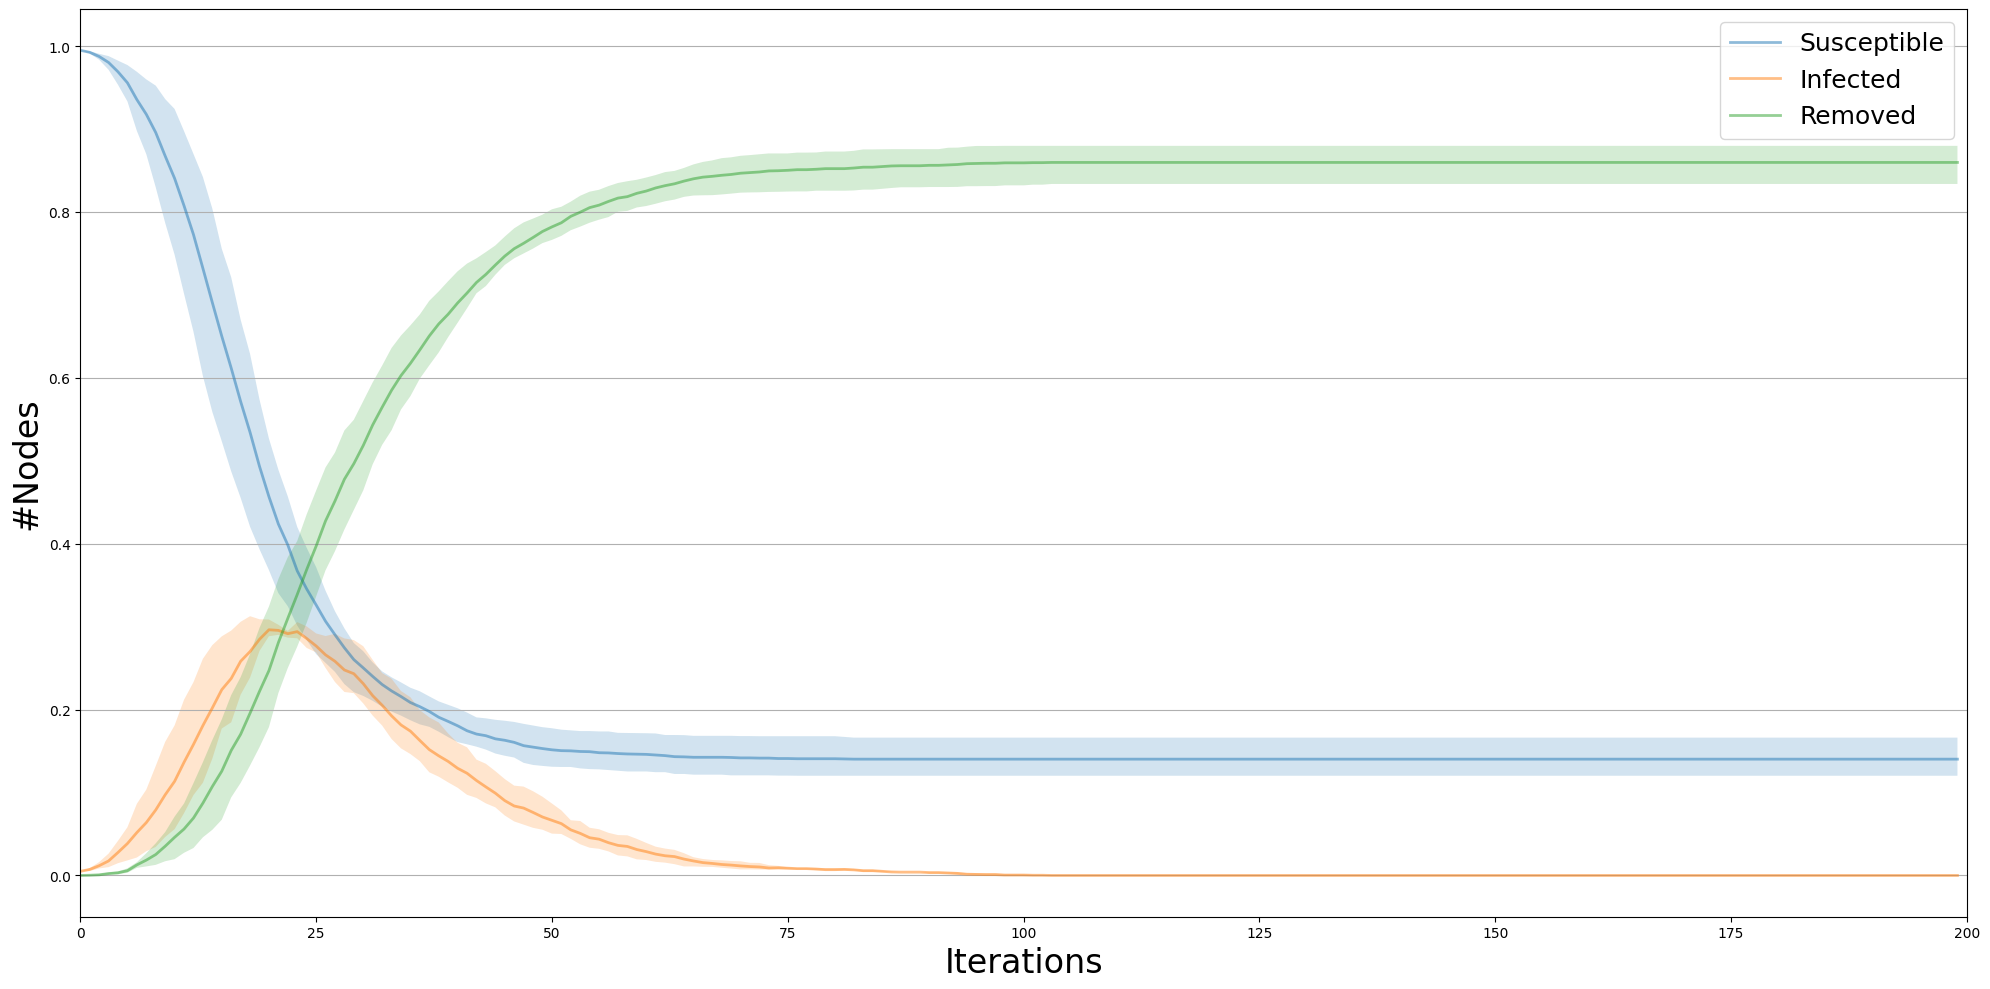

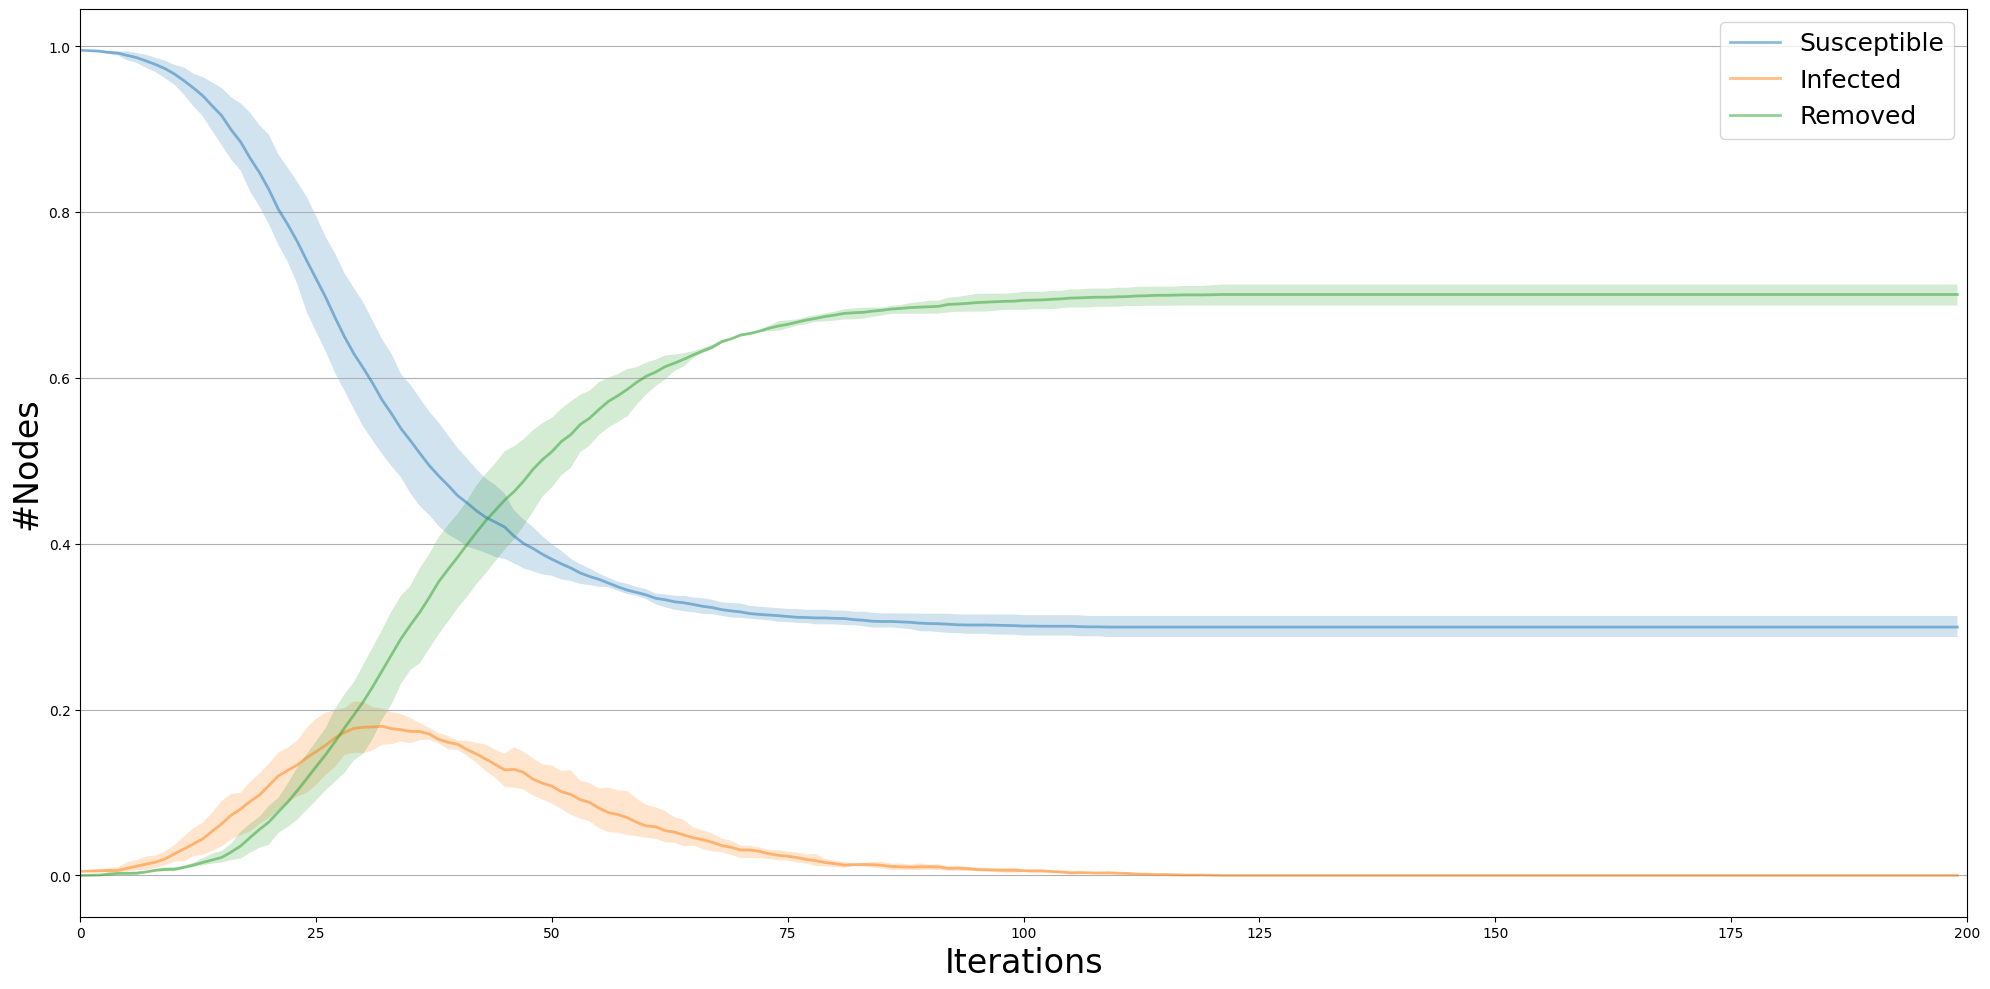

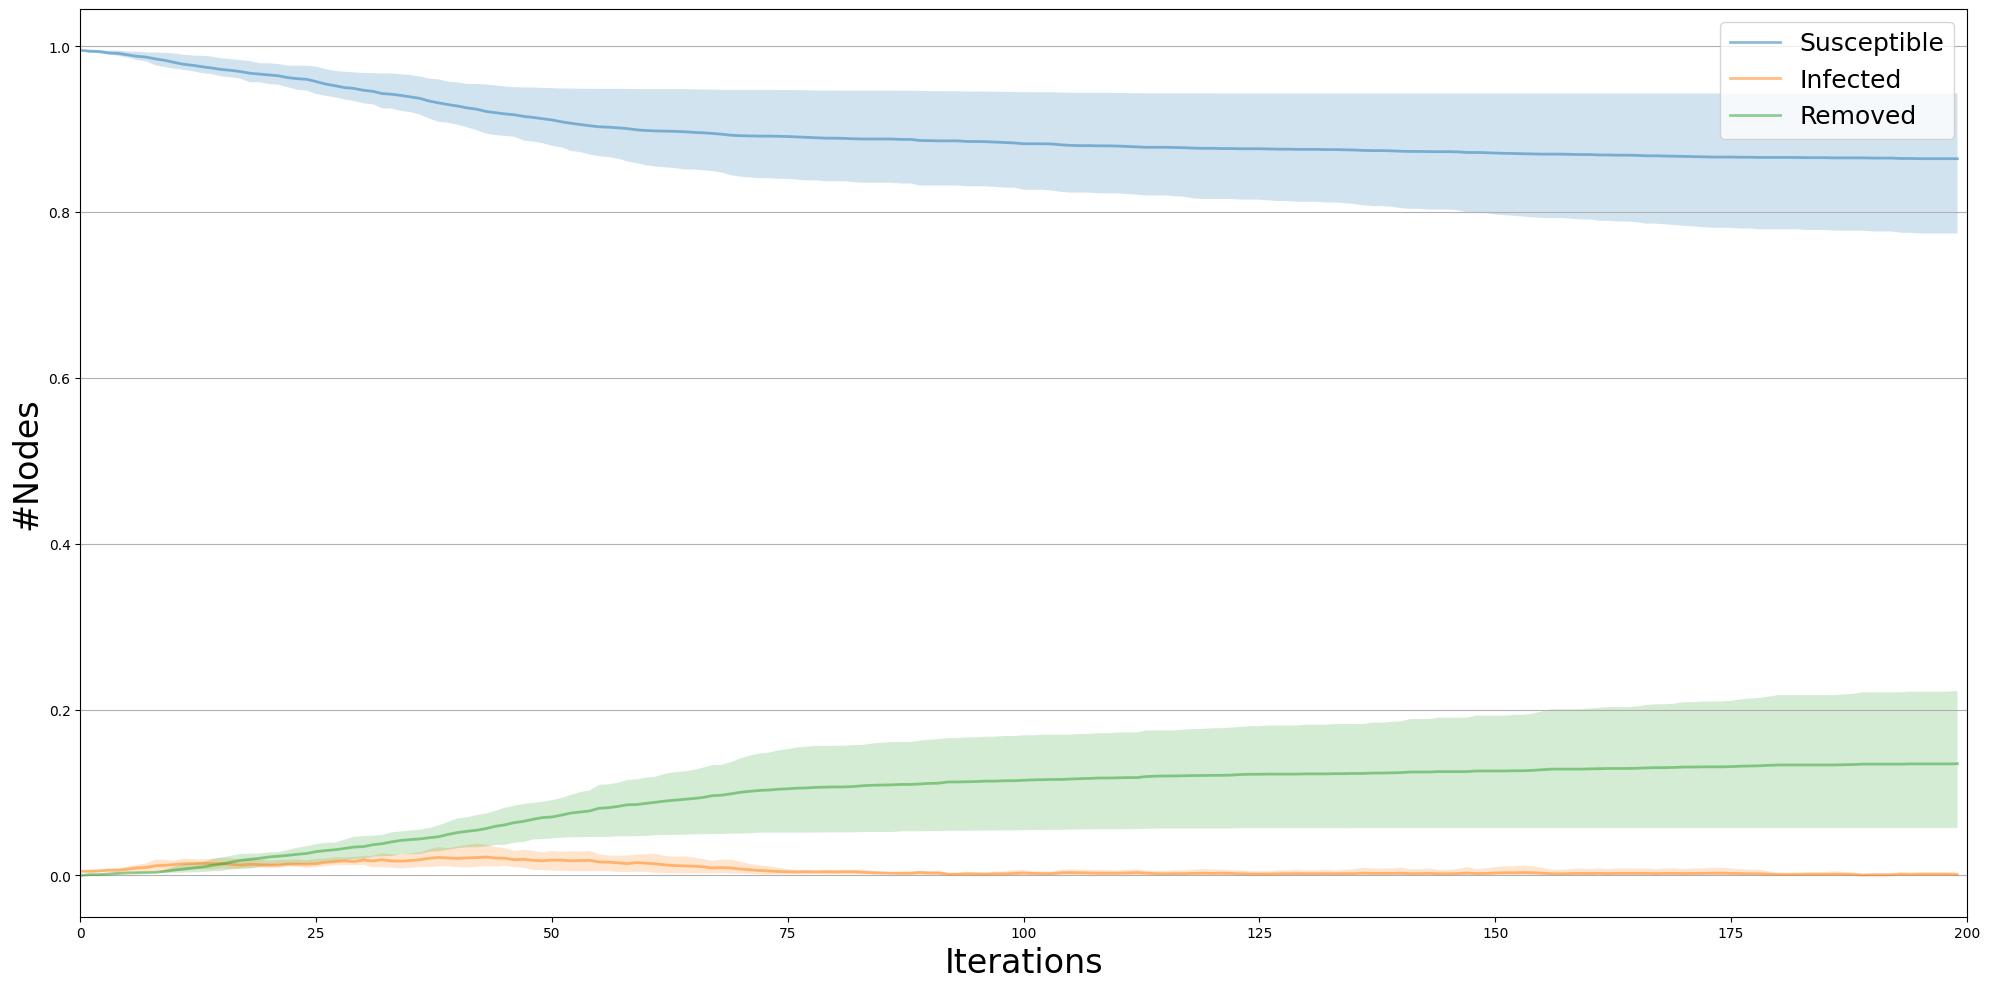

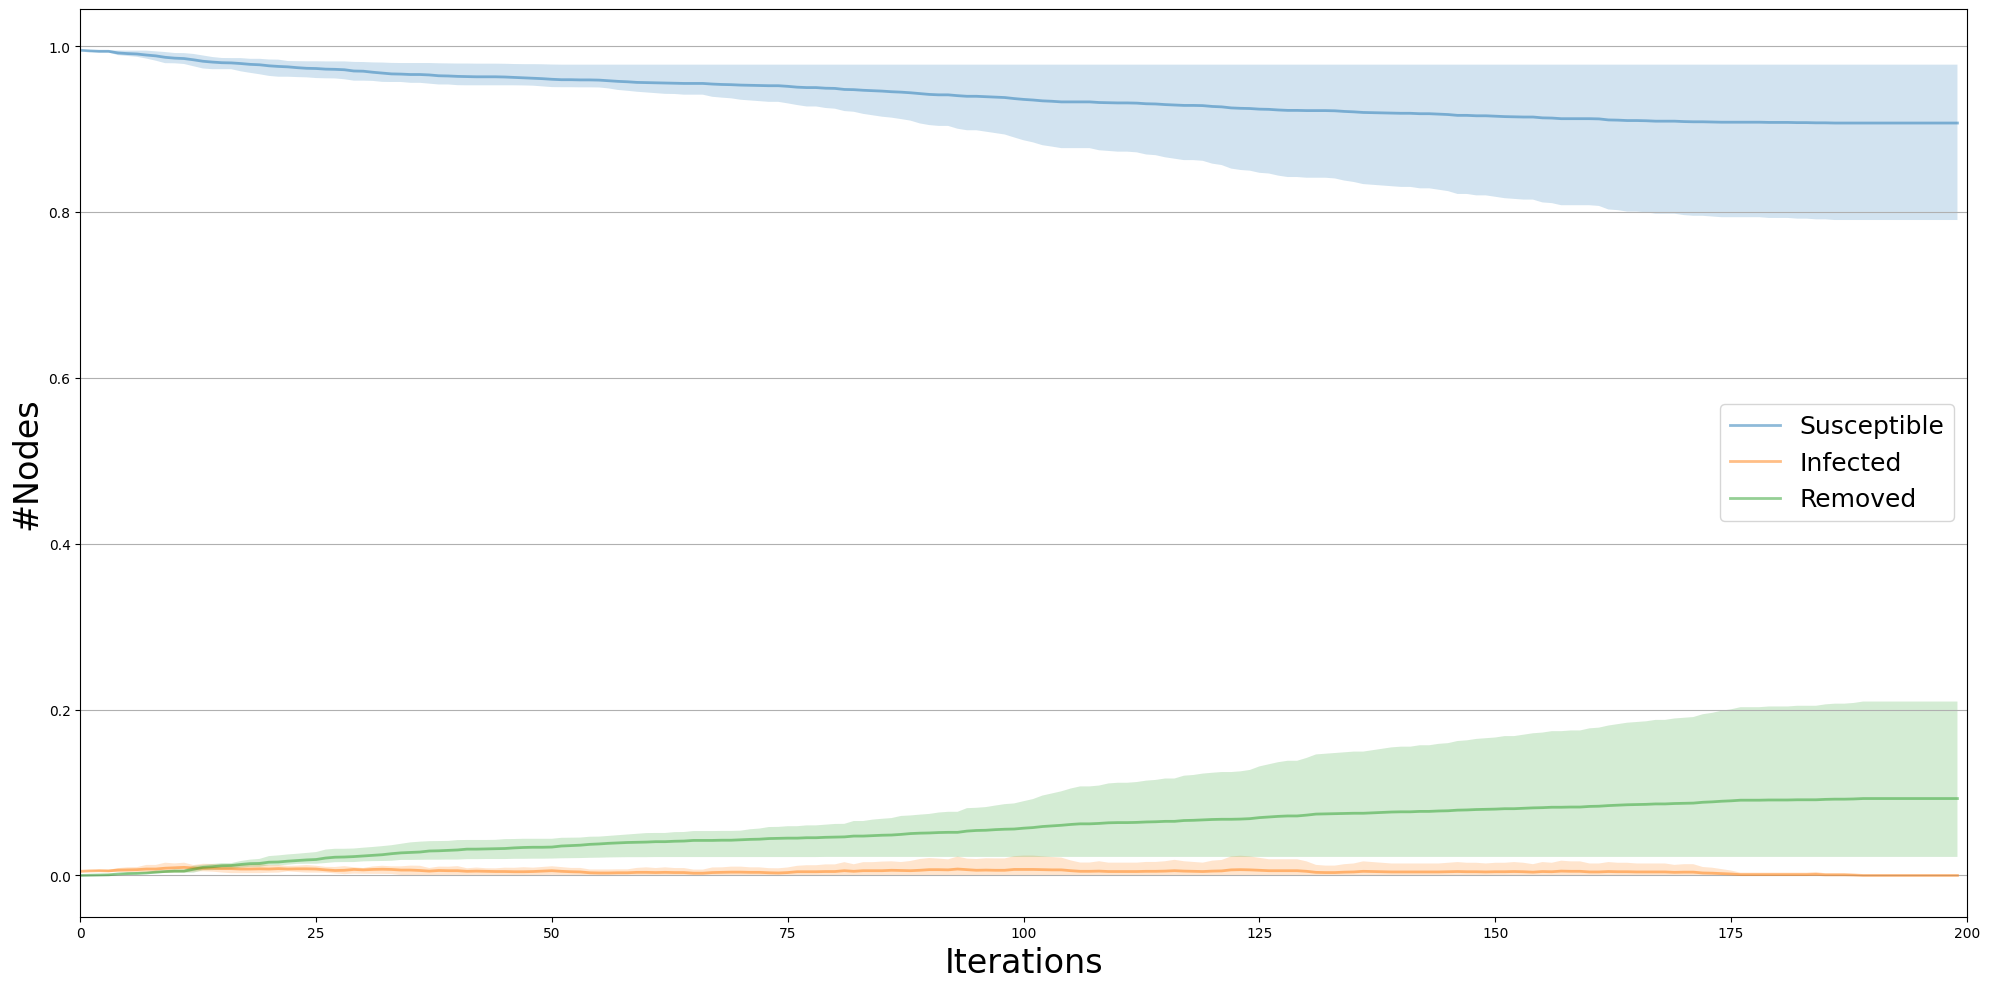

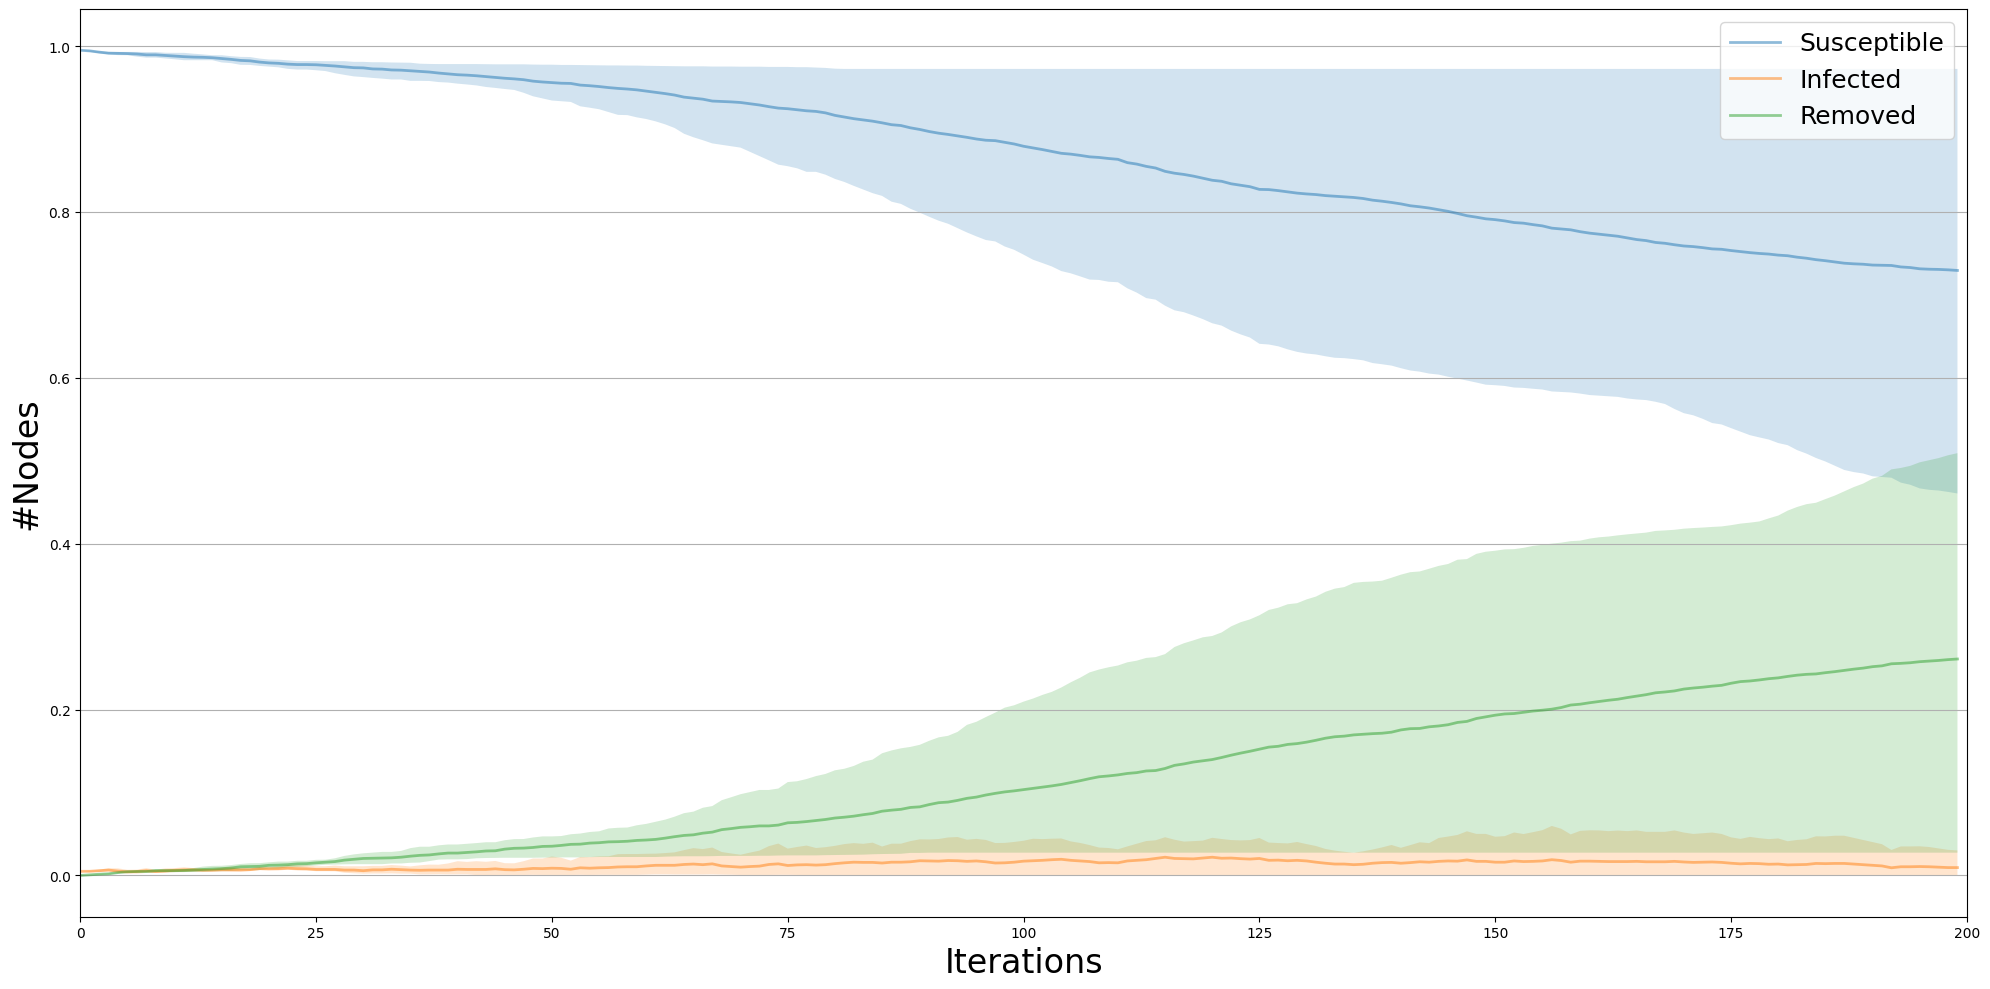

In [9]:
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs


# nx.draw_networkx_edges(graph,pos=nx.spring_layout(graph))
def give_plot(graph, rule=None):
    model = ep.SIRModel(graph)

    ## configuring model

    config = mc.Configuration()
    config.add_model_parameter("beta", 1 / 100)
    config.add_model_parameter("gamma", 1/10)
    config.add_model_parameter("fraction_infected", 5/len(graph.nodes))
    model.set_initial_status(config)

    ## Excuting the simulation

    trends = multi_runs(model, execution_number=4, iteration_number = 200, nprocesses=4) 

    ## Visualizing
    visual = DiffusionTrend(model, trends)
    return visual.plot(percentile=95)


graphER = nx.erdos_renyi_graph(1000, 0.02)
graphER1 = nx.erdos_renyi_graph(1000, 0.015)
graphER2 = nx.erdos_renyi_graph(1000, 0.01)
graphBA = nx.barabasi_albert_graph(1000, 20)
graphBA1 = nx.barabasi_albert_graph(1000,15)
graphBA2 = nx.barabasi_albert_graph(1000,10)
graphWS = nx.watts_strogatz_graph(1000,20,0)
graphWS1 = nx.watts_strogatz_graph(1000,15,0.2)
graphWS2 = nx.watts_strogatz_graph(1000,16,1 )
graphs = [graphER, graphER1, graphER2, graphBA, graphBA1, graphBA2, graphWS, graphWS1, graphWS2]

for plot,graph in enumerate(graphs):
    give_plot(graph)

## SIR NETWORKS
In SIR networks, beta should(?) be smaller than gamma in order to get similar behavior to a regular SIR. Not true?

ER: Homogenous mixing, and we expect all nodes to have the "average" number of edges, which leads to little to no pockets for the infection to get stuck in. Changing beta 
 - For low value of P, the disease does not infect all susceptibles, it most likely gets stuck source:Amir

BA: Any node is most likely connected to a hub, therefore it is very unlikely to get "stuck" somewhere where the disease has no susceptibles to spread to. 

WS: When taking k to be the mean degree of an ER model and setting P to 1, we expect WS and ER to behave very similarly. considering the graph is now fully randomly initialize.


<Axes: title={'center': 'Random Strategies'}>

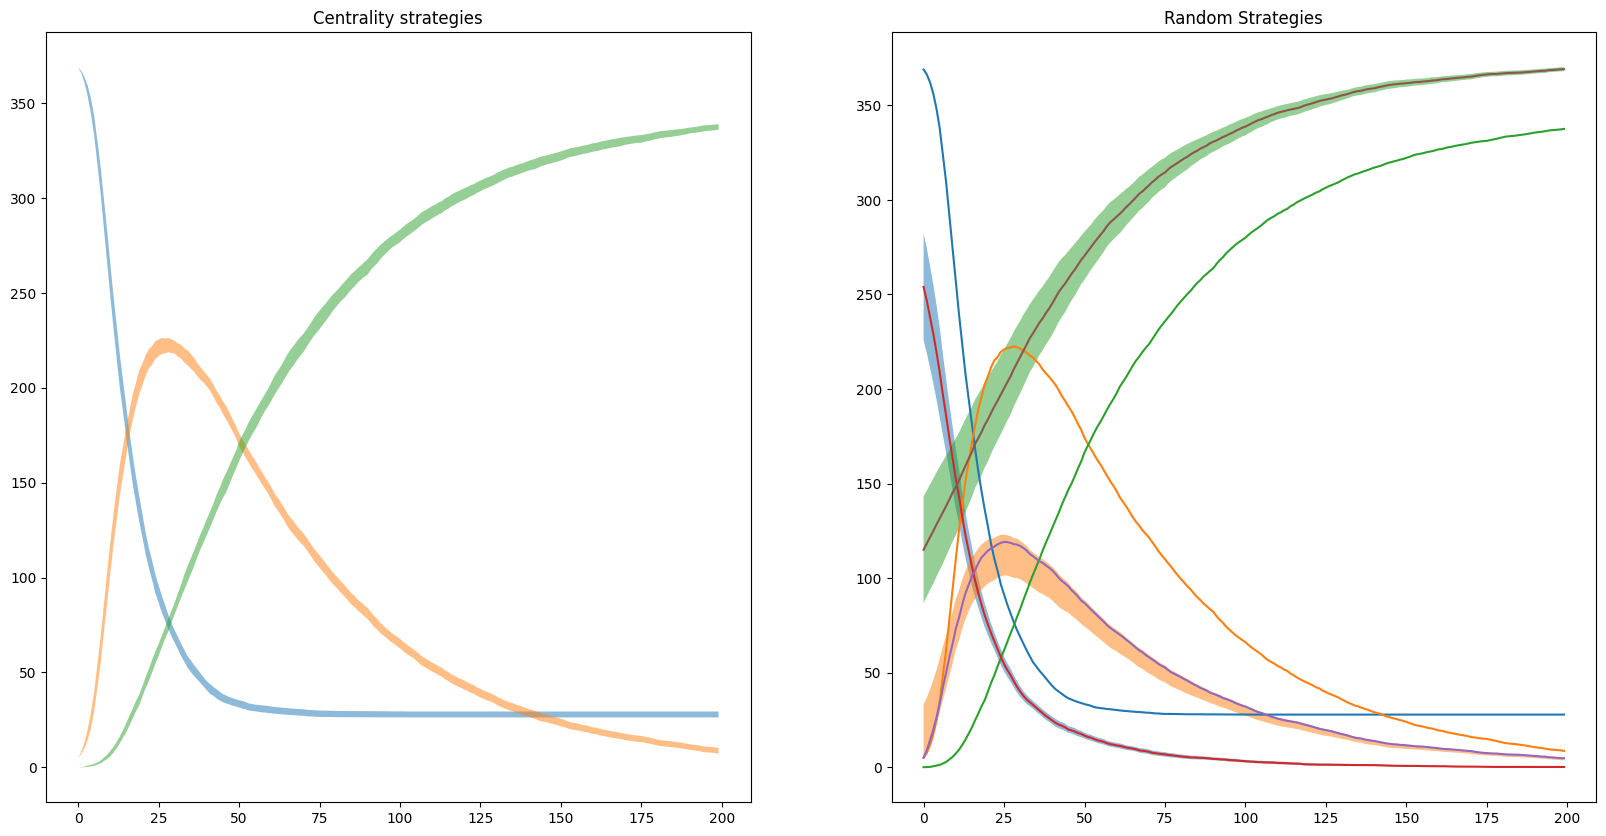

In [19]:
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cpm

f = pd.read_csv("transmission_network.csv", header=0, index_col=0, delimiter=";")
# Removing the weights
for column in f.columns:
    f[column] = [1 if x else 0 for x in f[column]]
graph_part2 = nx.Graph(f.values)

class Simulation():
    def __init__(self, graph, iterations, tests, testIter, vaccines, infected, beta, gamma, vaccination_strat, testing_strat):
        """Init the simulation with a graph, the total number of available tests, the number of vaccines for each iteration, the number of infected individuals at the start and the vaccination strategy"""
        self.graph = graph
        self.iterations = iterations
        self.tests = tests
        self.testIter = testIter
        self.vaccines = vaccines
        self.infected = infected
        self.beta = beta
        self.gamma = gamma
        self.Nnodes= len(self.graph.nodes())
        self.testing = testing_strat
        self.prep_vaccine = vaccination_strat
        


        self.id= {n: {"id": id} for id,n in enumerate(self.graph.nodes())}
        self.checked = {n: {"check": "Susceptible"} for i,n in enumerate(self.graph.nodes())}
        nx.set_node_attributes(self.graph, self.id)
        nx.set_node_attributes(self.graph, self.checked) 
        
        self.current_iteration = 0
        self.vaccine_targets = []
        self.history= []
        self.iterationBunch = []
        self.model = None
        self.trends = None
       
    def setup_model(self):
        self.trends =  None
        self.model = gc.CompositeModel(self.graph)

        self.model.add_status("Susceptible")
        self.model.add_status("Infected")
        self.model.add_status("Recovered")        
        config = mc.Configuration()
        infections = np.random.randint(self.Nnodes, size=self.infected)
        config.add_model_initial_configuration("Infected", infections)


        # c1 and c2 are the rules for spread and recovered, the trigger status means that it is based on the number of neighbors
        c1 = cpm.NodeStochastic(self.beta, triggering_status="Infected")
        c2 = cpm.NodeStochastic(self.gamma)
        self.model.add_rule("Susceptible", "Infected", c1)
        self.model.add_rule("Infected", "Recovered", c2)
        
        self.model.set_initial_status(config)
        
        
    def vaccination(self):
        for node in self.graph.nodes():
            if node in self.vaccine_targets and self.model.status[node] == 0:
                self.model.status[node] = 2
        [self.history.append(x) for x in self.vaccine_targets]
        self.vaccine_targets = []
        
    def run(self, N):
        S = np.ndarray((N,self.iterations))
        I = np.ndarray((N,self.iterations))
        R = np.ndarray((N,self.iterations))
        for _ in range(N):
            for i in range(self.iterations):
                self.testing(self)
                self.prep_vaccine(self)
                self.vaccination()
                self.iterationBunch.append(self.model.iteration())
            data = self.model.build_trends(self.iterationBunch)[0]['trends']['node_count']
            S[_,:] =  data[0][-self.iterations:]
            I[_,:] =  data[1][-self.iterations:]
            R[_,:] =  data[2][-self.iterations:]
            self.setup_model()
            self.model.reset()
        return [S,I,R] 


def random_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible"]
    if available:
        simulation.vaccine_targets = np.random.choice(available, size=simulation.vaccines)
        
def random_testing(simulation):
    testing = np.random.choice(simulation.graph.nodes(), size= simulation.testIter)
    for node in testing:
        simulation.graph.nodes[node]["check"] = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
        # status = actual_status
        # test_result = np.random.choice([acutal_status, Susceptiplbe], [accuray, 1-accuary])
        simulation.tests -= 1
        
## Centrality measures
def centrality_vaccination(simulation):
    available = {node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history}
    
    targets = sorted(simulation.graph.degree(), key=lambda x: x[1], reverse=True)
    available_target = [node for node,_ in targets if node in available]
    simulation.vaccine_targets = available_target[:simulation.vaccines]

## Centrality measures
def closeness(simulation):
    available = {node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history}
    while len(simulation.vaccine_targets) > simulation.vaccines:
        initial_nodes = np.random.choice(available, size=5)
        for j in initial_nodes:
            neighbor = np.random.choice(simulation.graph.neighbors(j), size=1)
            if len(simulation.vaccine_targets) > simulation.vaccines:
                simulation.vaccine_targets.append(neighbor)
                
def vaccinate_by_edge_cut():
    pass

def baseline(args):
    pass

def centrality_testing(simulation):
    # available = {node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history}

    testing = sorted(simulation.graph.degree(), key=lambda x: x[1], reverse=True)
    for node in testing:
        simulation.graph.nodes[node[0]]["check"] = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node[0]]] ## Poor man's dictionary
        # status = actual_status
        # test_result = np.random.choice([acutal_status, Susceptiplbe], [accuray, 1-accuary])
        simulation.tests -= 1
    # available_target = [node for node,_ in targets if node in available]

def plot_data(data, ax, percentile=90, title=False):
    S,I,R = data[0],data[1],data[2]
    meanS = np.mean(S,axis=0)
    meanI = np.mean(I,axis=0)
    meanR = np.mean(R,axis=0)
    
    varS = np.std(S,axis=0)
    varI = np.std(I,axis=0)
    varR = np.std(R,axis=0)
    
    x_axis = range(len(meanS))
    ax.set_title(title)
    # for i in range(S.shape[0]):
        # ax.plot(x_axis, S[i], color = "b")
    plt.plot(x_axis, meanS)
    ax.fill_between(x_axis, meanS + 0.45*varS, meanS- 0.45*varS, alpha= 0.5)
    # for i in range(S.shape[0]):
        # ax.plot(x_axis, I[i], color = "orange")
    plt.plot(x_axis, meanI)
    ax.fill_between(x_axis, meanI + 0.45*varS, meanI- 0.45*varI, alpha= 0.5)
    # for i in range(S.shape[0]):
        # ax.plot(x_axis, R[i], color = "g")
    plt.plot(x_axis, meanR)
    ax.fill_between(x_axis, meanR + 0.45*varR, meanR- 0.45*varR, alpha= 0.5)
    return ax

kwargs = {
    "graph": graph_part2,
    "iterations": 200,
    "tests": 200,
    "testIter":10,
    "vaccines": 5,
    "infected": 5,
    "beta": 1/10,
    "gamma": 1/50,
    "vaccination_strat": baseline,
    "testing_strat": baseline,  
}
runs = 30
fig,ax = plt.subplots(1,2, figsize=(20,10))
ax.ravel()
sim = Simulation(**kwargs)
sim.setup_model()
closeness_data = sim.run(runs)
plot_data(closeness_data, ax[0], 90, "Centrality strategies")

kwargs["vaccination_strat"] = random_vaccination
kwargs["testing_strat"] = random_testing
sim = Simulation(**kwargs)
sim.setup_model()
random_data = sim.run(runs)
plot_data(random_data, ax[1], 90, "Random Strategies")